# 2MBA30 2025-2026 Q2 - Modeling Assignment

## Introduction to this template notebook

* This is a **personal** notebook. 
* Make sure you work in a **copy** of `...-template.ipynb`,
    **renamed** to `...-firstIDnr-secondIDnr.ipynb`,
    where `yourIDnr` is your TU/e identification number.  
* In case of two authors, include both ID numbers:
    `...-firstIDnr-secondIDnr.ipynb`.

Proceed in this notebook as follows:
* **Personalize** the notebook (see below)
* **Read** the text.
* **Do** the assignment.
* **Run** _all_ code cells (also the ones _without_ your code),
    _in linear order_ from the first code cell.

**Personalize your notebook**:
1. Copy the following lines of code (`AUTHOR2_...` only when applicable):

  ```python
  AUTHOR_NAME = 'Your Full Name'
  AUTHOR_ID_NR = '1234567'
  AUTHOR_DATE = 'YYYY-MM-DD'  # when first modified, e.g. '2019-02-26'

  AUTHOR2_NAME = 'Not Applicable'
  AUTHOR2_ID_NR = 'Not Applicable'
  ```

1. Paste them between the marker lines in the next code cell.
1. Fill in your _full name_, _identification number_, and the current _date_ as strings between quotes.
1. When applicable, also copy and fill in the name and id.nr. for the second author.
1. Run the code cell by putting the cursor there and typing **Control-Enter**.

In [1]:
#// BEGIN_TODO [Author] Name, Id.nr., Date, as strings

AUTHOR_NAME = "Andreas Theocharous"
AUTHOR_ID_NR = "2379554"
AUTHOR_DATE = "2025-12-01"


AUTHOR2_NAME = 'Rareș Ouatu'
AUTHOR2_ID_NR = '2141035'

#// END_TODO [Author]

AUTHOR_NAME, AUTHOR_ID_NR, AUTHOR_DATE, AUTHOR2_NAME, AUTHOR2_ID_NR

('Andreas Theocharous', '2379554', '2025-12-01', 'Rareș Ouatu', '2141035')

Everything between the horizontal lines below is for your solution to the modeling assignment. You can add additional subsections to provide further structure within the sections in the template. The template serves as a guideline, and you are allowed to change it.

---

# $$\textbf{\Large{Eredivisie Seasonal Analysis}}$$

In [2]:
# Imports
from typing import Any, Optional

import pandas as pd                  # Importing and manipulating data frames 
import matplotlib.pyplot as plt      # Creating plots
from datetime import datetime        # Work with datestamps

import math


## $$\textbf{INTRODUCTION}$$

This report develops and evaluates an Elo-based framework to identify the strongest team in the Eredivisie. Using match data from the previous three seasons, the model tracks team strength dynamically rather than relying on end-of-season league standings outcomes alone. Elo provides a transparent, competition-agnostic way to compare teams through time by updating ratings after each match in proportion to how surprising the result is relative to prior ratings. In the football setting, expected winners gain little from routine victories, while underdogs gain substantially more when outperforming expectation, giving a more reliable measure of relative strength as more match results are observed. Building on this baseline, the report analyses the evolution of ratings over each season and uses complementary diagnostics, such as time-series and attack–defence decompositions to distinguish sustained dominance from short-run fluctuations, with the ultimate aim of determining which club is most consistently strongest under the fitted model.

## $$\textbf{PART 1: DATA ANALYSIS}$$

This report starts with a brief qualitative analysis of the data. Below the relevant data points and their corresponding abbreviations, where applicable, are presented.

- `Date`
- `HomeTeam`
- `AwayTeam`
- `FTR` - Full Time Result
- `FTHG` - Full Time Home Goals 
- `FTAG` - Full Time Away Goals


#### $$\textbf{Initial Plotting of data}$$

The data is subsequently subjected to quantitative assessment. Plots are created to illustrate how far along the current league the available dataset extends, thereby providing an initial impression of team performance across different seasonal periods. Two types of plots are created, depicting the following:

- total wins and losses per team per season (disaggregated into home and away)
- total goals per team per season  (disaggregated into home and away)


In [3]:
df = pd.read_csv('data/eredivisie.csv')

# we only care about these columns, so we filter our dataframe accordingly
df = df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]]

# we created some variables for key dates of the three seasons we have data for (dates were found online)
Y_2025_START = datetime(2025, 8, 8)
Y_2025_END = datetime(2026, 5, 17)

Y_2024_START = datetime(2024, 8, 9)
Y_2024_END = datetime(2025, 6, 1)

Y_2023_START = datetime(2023, 8, 11)
Y_2023_END = datetime(2024, 5, 19)

Y_2022_START = datetime(2022, 8, 5)
Y_2022_END = datetime(2023, 5, 28)

# to be able to compare the dates in the dataframe with out season start/end dates 
# we need to convert the date strings into datetime objects
df["Date"] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

results = { "H": 1, "D": 0.5, "A": 0 }

# we create a new column using the values of the FTR column as keys to the results dictionary
df['R_actual'] = df['FTR'].map(results)


The total number of matches per season is given below. It is noted that the dataset used in this report contains incomplete information for the 2025–2026 season, as only 117 of the 306 matches have been played at the time of writing.

In [4]:
# the number of matches per season is equal to the number of rows of the filtered dataframe
total_matches_25_26 = len(df[(df["Date"] >= Y_2025_START) & (df["Date"] <= Y_2025_END)])
total_matches_24_25 = len(df[(df["Date"] >= Y_2024_START) & (df["Date"] <= Y_2024_END)])
total_matches_23_24 = len(df[(df["Date"] >= Y_2023_START) & (df["Date"] <= Y_2023_END)])
total_matches_22_23 = len(df[(df["Date"] >= Y_2022_START) & (df["Date"] <= Y_2022_END)])

# count the number of matches per season (fixed for previous seasons, variable for the ongoing season)
seasons = ["2022-2023", "2023-2024", "2024-2025", "2025-2026"]
matches_per_season = [total_matches_22_23, total_matches_23_24, total_matches_24_25, total_matches_25_26]

for i in range(4):
    print(f"The total number of matches in {seasons[i]} is {matches_per_season[i]}")


The total number of matches in 2022-2023 is 306
The total number of matches in 2023-2024 is 306
The total number of matches in 2024-2025 is 306
The total number of matches in 2025-2026 is 117


In [5]:
def count_results_per_team(s_start: datetime, s_end: datetime) -> dict[str, dict[str, dict[str,int]]]:
    """
    Counts the number of wins, losses and draws of team for the given season counted separately for home and away games

    :param s_start: datetime the start date of this season
    :param s_end: datetime the end date of this season

    :returns: dict which maps each team to another dict keeping track of the number of wins losses of a team at home and away games
    """
    season_df = df[(df["Date"] >= s_start) & (df["Date"] <= s_end)]

    all_teams = season_df["HomeTeam"].unique()

    wins_losses_per_team = {}
    for team in all_teams:
        wins_losses_per_team[team] = { 
            "Home": { "W": 0, "D": 0,  "L": 0 }, 
            "Away": { "W": 0, "D": 0,  "L": 0 } 
        }

    # for each team in the season
    for team in all_teams:   
        # filter the dataframe to only show rows where this team is playing at home and the result is H, D, A respectively
        home_wins = len(season_df[(season_df["HomeTeam"] == team) & (season_df["FTR"] == "H")])
        home_draws = len(season_df[(season_df["HomeTeam"] == team) & (season_df["FTR"] == "D")])
        home_losses = len(season_df[(season_df["HomeTeam"] == team) & (season_df["FTR"] == "A")])

        wins_losses_per_team[team]["Home"]["W"] = home_wins
        wins_losses_per_team[team]["Home"]["D"] = home_draws
        wins_losses_per_team[team]["Home"]["L"] = home_losses
        
        # filter the dataframe to only show rows where this team is playing away and the result is A, D, H respectively
        away_wins = len(season_df[(season_df["AwayTeam"] == team) & (season_df["FTR"] == "A")])
        away_draws = len(season_df[(season_df["AwayTeam"] == team) & (season_df["FTR"] == "D")])
        away_losses = len(season_df[(season_df["AwayTeam"] == team) & (season_df["FTR"] == "H")])

        wins_losses_per_team[team]["Away"]["W"] = away_wins
        wins_losses_per_team[team]["Away"]["D"] = away_draws
        wins_losses_per_team[team]["Away"]["L"] = away_losses
    
    return wins_losses_per_team
    

def plot_results_per_team_for_season(seasons: list[tuple[datetime, datetime]]):
    """
    Plots the wins losses and draws per team for multiple seasons in a subplot
    
    :param seasons: list of tuples containing (start_date, end_date) for each season

    :returns: None
    """

    # Create subplot grid - 2x2 for 4 plots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    axes = axes.flatten()

    for (season_index, (s_start, s_end)) in enumerate(seasons):
        wins_losses_per_season = count_results_per_team(s_start, s_end)
        teams = sorted(list(wins_losses_per_season.keys()))
        
        wins_home = []
        wins_away = []
        draws_home = []
        draws_away = []
        losses_home = []
        losses_away = []
        for team in teams:
            wins_home.append(wins_losses_per_season[team]["Home"]["W"])
            wins_away.append(wins_losses_per_season[team]["Away"]["W"])
            draws_home.append(wins_losses_per_season[team]["Home"]["D"])
            draws_away.append(wins_losses_per_season[team]["Away"]["D"])
            losses_home.append(wins_losses_per_season[team]["Home"]["L"])
            losses_away.append(wins_losses_per_season[team]["Away"]["L"])

        axes[season_index].bar(teams, losses_home, label='Losses Home', color='#dc2626')
        axes[season_index].bar(teams, losses_away, label='Losses Away', color='#f87171', bottom=losses_home)
        
        # we need to tell matplotlib where to start drawing the rest the next section of each bar
        # to do that we must sum the existing losses both home and away for each team
        # the same must be done for each subsequent bar segment
        total_losses = []
        for i in range(len(teams)):
            total_losses.append(losses_home[i] + losses_away[i])

        axes[season_index].bar(teams, draws_home, label='Draws Home', color='#f59e0b', bottom=total_losses)

        total_losses_and_draws_home = []
        for i in range(len(teams)):
            total_losses_and_draws_home.append(total_losses[i] + draws_home[i])

        axes[season_index].bar(teams, draws_away, label='Draws Away', color='#fcd34d', bottom=total_losses_and_draws_home)

        total_losses_and_draws = []
        for i in range(len(teams)):
            total_losses_and_draws.append(total_losses_and_draws_home[i] + draws_away[i])
        
        axes[season_index].bar(teams, wins_home, label='Wins Home', color='#4d7c0f', bottom=total_losses_and_draws)

        total_losses_draws_and_wins_home = []
        for i in range(len(teams)):
            total_losses_draws_and_wins_home.append(total_losses_and_draws[i] + wins_home[i])
            
        axes[season_index].bar(teams, wins_away, label='Wins Away', color='#84cc16', bottom=total_losses_draws_and_wins_home)

        axes[season_index].set_xlabel('Team')
        axes[season_index].set_ylabel('Wins/Draws/Losses')
        axes[season_index].set_title(f'Match Results per Team ({s_start.year}-{s_end.year})')
        axes[season_index].tick_params(axis='x', rotation=45, labelsize=8)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=6)

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [6]:
def count_goals_per_team(s_start: datetime, s_end: datetime) -> dict[str, dict[str,int]]:
    """
    Counts the number of goals each team scored for the given season

    :param s_start: datetime the start date of this season
    :param s_end: datetime the end date of this season

    :returns: dict which maps each team to the total number of goals they scored
    """
    season_df = df[(df["Date"] >= s_start) & (df["Date"] <= s_end)]

    all_teams = season_df["HomeTeam"].unique()

    goals_per_team = {}
    for team in all_teams:
        goals_per_team[team] = { "Home": 0, "Away": 0 }

    # for each team in the season
    for team in all_teams:
        
        # filter the dataframe to only show rows where this team is playing at home
        home_matches = season_df[season_df["HomeTeam"] == team]
        # sum the number of goals in the column FTHG
        home_goals = sum(home_matches["FTHG"])
        goals_per_team[team]["Home"] = home_goals
        
        # filter the dataframe to only show rows where this team is playing away
        away_matches = season_df[season_df["AwayTeam"] == team]
        # sum the number of goals in the column FTAG
        away_goals = sum(away_matches["FTAG"])
        goals_per_team[team]["Away"] = away_goals
    
    return goals_per_team
    

def plot_goals_per_team_for_season(seasons: list[tuple[datetime, datetime]]):
    """
    Plots the home and away goals per team for multiple seasons in a subplot

    :param seasons: list of tuples containing (start_date, end_date) for each season

    :returns: None
    """

    # Create subplot grid - 2x2 for 4 plots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    axes = axes.flatten()

    for (i, (s_start, s_end)) in enumerate(seasons):
        goals_per_season = count_goals_per_team(s_start, s_end)
        teams = sorted(list(goals_per_season.keys()))

        home_goals = []
        away_goals = []
        for team in teams:
            home_goals.append(goals_per_season[team]["Home"])
            away_goals.append(goals_per_season[team]["Away"])

        axes[i].bar(teams, home_goals, label='Home', color='#38bdf8')
        axes[i].bar(teams, away_goals, label='Away', color='#4f46e5', bottom=home_goals)
        axes[i].set_xlabel('Team')
        axes[i].set_ylabel('Goals Scored')
        axes[i].set_title(f'Goals per Team ({s_start.year}-{s_end.year})')
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2)

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

#### $$\textbf{Match Results per Team per Season}$$

The stacked bar charts below summarise, for each club and season, the decomposition of match outcomes into wins, draws, and losses corresponding to green, yellow and red respectively. Each grouping is further split into darker and lighter variants with the darker and lighter corresponding to home and away results respectively. Consequently, the total height of each bar equals to 34, the total number of matches in a full Erdivisie season per team, with the exception of the current season where only 13 matches have been recorded. 

Per team aggregation is chosen because the objective is to compare club-level performance profiles, not just league-wide averages. If results were pooled across teams, differences between strong and weak clubs and differences in home–away asymmetry would be averaged out, making it impossible to attribute patterns such as home strength or away weakness to specific teams.

Per season separation is used to keep comparisons context consistent. Seasons differ in participating clubs and, possibly, in underlying conditions such as managerial changes so grouping across seasons and can produce misleading "average" profiles.

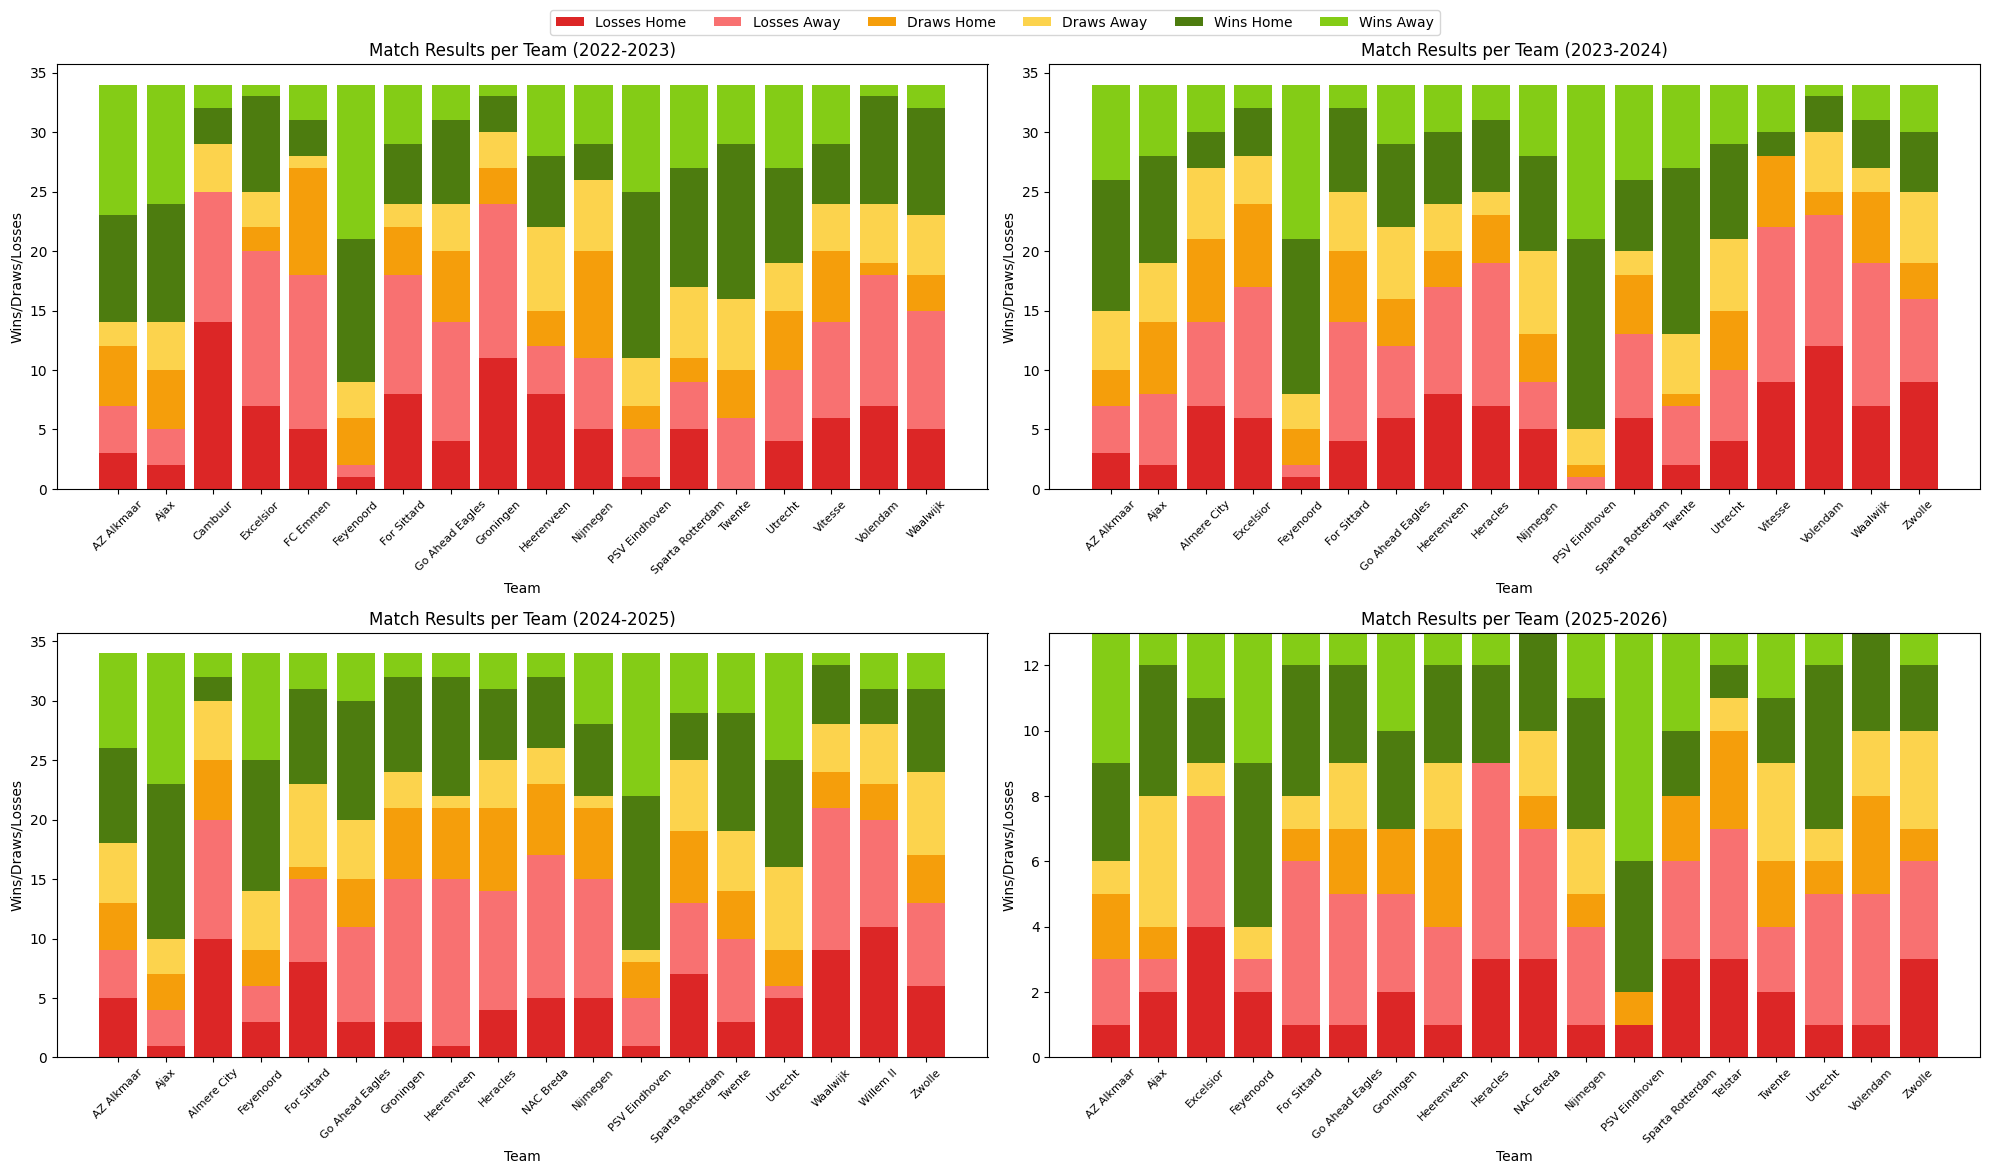

In [7]:
plot_results_per_team_for_season([
    (Y_2022_START, Y_2022_END),
    (Y_2023_START, Y_2023_END),
    (Y_2024_START, Y_2024_END),
    (Y_2025_START, Y_2025_END)
])

#### $$\textbf{Analysis}$$

For the 2022–2023 season , the distribution of outcomes indicates a clear performance stratification: Feyenoord appears as the strongest by total wins and is also among the leading teams in away wins, while PSV Eindhoven and AZ Alkmaar form the next tier by total wins and/or away performance. At the opposite extreme, Cambuur exhibits the largest loss count overall and, in particular, the largest number of home losses. FC Emmen and Nijemen sit in a comparatively "draw-prone" regime, suggesting equilibrium where neither consistent conversion to wins nor persistent vulnerability to losses dominates. Moreover, a number of top teams (including AZ Alkmaar, Ajax, Feyenoord, PSV Eindhoven, and Twente) remain at very low total loss count. Finally, Feyenoord's home losses are absent and away losses minimal

In 2023–2024, the figure shows a pronounced dominance by PSV Eindhoven: their bar is overwhelmingly composed of wins, with only a very small remainder of non-wins, and losses essentially negligible relative to the performance of other teams. Feyenoord follows as the next-strongest profile, again characterised by a high win share and very limited losses. Moreover, Volendam's bar contains one of the smallest win totals overall and is dominated by losses. More broadly, the 2023–2024 group of teams strongly exhibits "home advantage" in the sense that most teams show larger home-win segments than away-win segments, while losses tend to accumulate more heavily away than at home, a pattern that is visually consistent across much of the league. Draws are comparatively compressed across teams and most clubs' draw rates lie in a similar band. Finally, PSV and Feyenoord have a near-absence of away losses.

For 2024–2025, the chart demonstrates that PSV Eindhoven again appears as the most successful team by total wins, the middle section clubs display more similar-looking mixtures of wins, draws, and losses than in the previous seasons. Moreover, the league's middle section club shows reduced spread in total wins relative to the gap between the top and bottom teams. The graph suggests a systematic home advantage, though there are a few clubs whose home/away loss balance looks closer to symmetric, indicating that not all underperformance is "away-driven". Moreover, Almere City has the fewest wins and finally, as in the prior season, draws remain comparatively stable across teams, which supports the interpretation that differences in league position are primarily driven by win conversion and loss avoidance rather than by unusually high or low draw rates.

For 2025–2026, the figure should be interpreted as representing an early stage of the season because the total bar heights are far below a full season total, sampling variability is large. Despite that, the graph still reveals meaningful structure. PSV Eindhoven again records the strongest start by total wins and their away-loss segment is absent. Feyenoord also shows a strong early profile, particularly in home wins, and Utrecht appears comparable in home-win accumulation. At the other end, Heracles' bar is dominated by losses, especially away losses while Excelsior exhibits the largest home-loss segment.

Across seasons, two regularities emerge. First, PSV Eindhoven's performance profile is consistently distinguished by win volume and loss absence. Second, the league-wide pattern repeatedly exhibits home advantage: Many clubs win more often at home and lose more often away, while draws remain comparatively clustered. Finally, since the 2025–2026 season is still incomplete, the right interpretive stance is probabilistic rather than definitive: the same visual diagnostics can be reported, but conclusions should be framed as preliminary trends that need confirmation as the sample approaches a full season's match count.

#### $$\textbf{Goals per Team per Season}$$

The figure below reports, for each season, the total number of goals scored by each team, decomposed into home and away goals scored corresponding to light and dark blue respectively. The stacked representations encode both overall attacking output (total bar height) and the extent to which that output depends on the venue (relative sizes of the home and away segments)

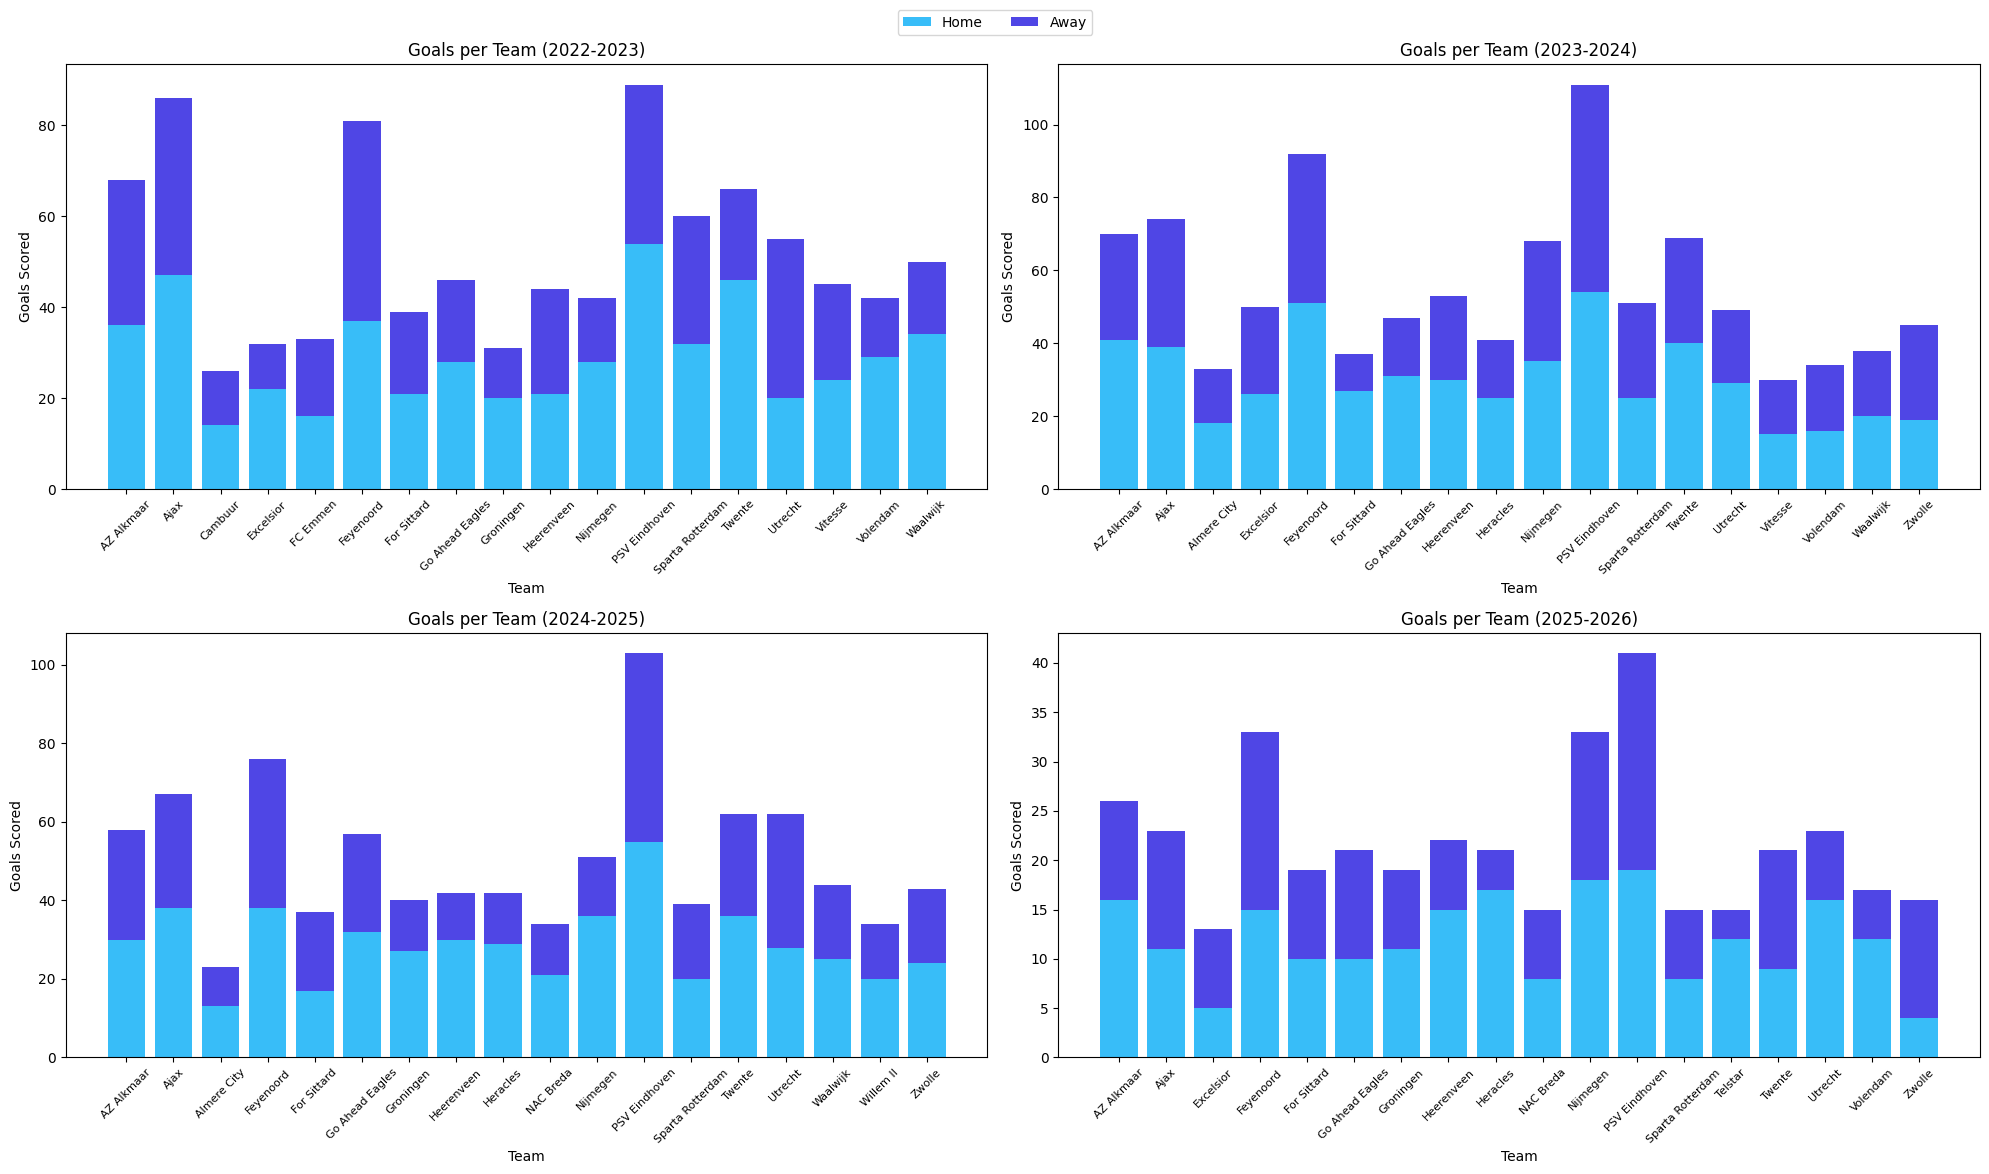

In [8]:
plot_goals_per_team_for_season([
    (Y_2022_START, Y_2022_END),
    (Y_2023_START, Y_2023_END),
    (Y_2024_START, Y_2024_END),
    (Y_2025_START, Y_2025_END)
])

#### $$\textbf{Analysis}$$

For the 2022–2023 season, the goals-per-team breakdown indicates a clearly right-skewed scoring distribution, with a small group of high-output attacks separated from a comparatively compressed middle section. PSV Eindhoven records the largest total goal count of all teams this season, narrowly ahead of Ajax, with Feyenoord forming a close third. Furthermore, Ajax appears relatively balanced, whereas PSV's total is noticeably more home-weighted, and Feyenoord's split slightly away-leaning. At the opposite end of the distribution, Cambuur is the lowest-scoring side by a clear margin, making them the most pronounced negative outlier in total goals. Beyond these extremes, most teams cluster in an intermediate range. Finally, dependence on the venue varies from club to club rather than exhibiting a single season-wide pattern.

In 2023–2024, PSV Eindhoven is a clear outlier at the top of the distribution, with the largest total goals and a near-even split between home and away scoring. Feyenoord is second with a substantial gap to most of the league, while Ajax and a small cluster of teams (including AZ Alkmaar, Twente, and Nijmegen) sit below that in a more compact group. At the lower end, Vitesse has the smallest total goal output in this season's league. Visually, the distribution is better characterised as unimodal. Finally, while many clubs show slightly higher home-goal segments than away-goal segments, this pattern is not universal since PSV's away output is at least comparable to their home output.

In 2024–2025, PSV Eindhoven again leads the league in total goals. Feyenoord appears second by total output, with Ajax third. However, the gap between Ajax and the next teams, namely Twente and Utrecht, is not large. Almere City is the lowest-scoring team in this season. Compared with the previous season, the league appears more compressed: the top end is still clearly defined, but the middle section totals are more densely packed. As with 2023–2024, there is evidence of a slight home advantage for many clubs.

In 2025–2026,  the data is based on an incomplete set of matches. The most robust statements one can make are therefore comparative rather than absolute. Within this partial sample, PSV Eindhoven again has the highest total goals, while  Nijmegen and Feyenoord are essentially tied as the next highest scorers. The bottom of the table is less sharply separated than in the completed seasons: Excelsior is the lowest-scoring team, but the gap to the next teams is small.

Across seasons, the common regularity is PSV Eindhoven's consistent position at the top of the scoring distribution, coupled with a relativelely balanced home–away contribution. A second consistent pattern is that most clubs' totals live in a mid-range zone, with seasonal differences in league shape, driven more by the existence of a few extreme high scorers and occasionally low scorers.

#### $$\textbf{Takeaway}$$
Across the seasons analysed, the results point to a stable performance hierarchy in both match outcomes and goal scoring. PSV Eindhoven and Feyenoord are consistently at the top. Below these two, the league is relatively compact, and differences in league position appear to be driven mainly by how often teams turn matches into wins and how well they avoid losses, since draw totals remain fairly similar across clubs and seasons. A recurring, though not universal, home advantage is visible in results; many teams win more often at home and lose more often away whereas goal scoring shows more variation in its home–away split from team to team. Finally, the partial 2025–2026 data shows similar patterns but should be treated cautiously, because early-season totals can change substantially as more matches are played.

## $$\textbf{PART 2: STANDARD ELO RATING MODEL}$$

#### $$\textbf{Creating the Model}$$
In this implementation of the Elo system, updates are symmetric: a rating increase of $\Delta E$ for one team corresponds to a decrease of $\Delta E$ for its opponent and all matches are simulated over a specified time period. The Elo rating of each team is initialised to 1500 and updated after every match result. 

The change in Elo rating following a match is computed using:

$$
\Delta E = k \cdot (R_{\text{actual}} - R_{\text{expected}})
$$,

where $k$ is a scaling factor and $R_{\text{actual}}, R_{\text{expected}}$ denote the actual and expected match outcomes respectively.

The expected result of a match is given by:

$$
R_{\text{expected}} = \frac{1}{1 + 10^{\frac{E_{\text{A}} - E_{\text{H}}}{400}}}
$$,

where $E_{\text{A}}, \ E_{\text{H}}$ denote the current Elos of the away and home team respectively.


In [9]:
def r_expected(elo_home: float, elo_away: float) -> float:
    """
    Computes the probability that the home team wins

    :param elo_home: float representing the current elo score of the home team
    :param elo_away: float representing the current elo score of the away team

    :returns: float representing the probability that the home team wins
    """
    return 1 / (1 + 10 ** ((elo_away - elo_home) / 400))


def delta_elo(r_actual: float, r_expected: float, k: float) -> float:
    """
    Computes the change in elo for the home team after a match is played

    :param r_actual: float the actual outcome of the match
    :param r_expected: float what our model predicts will be the outcome of the match
    :param k: float the k-factor
    
    :returns: float the change in elo for the home team
    """
    if k <= 0:
        raise Exception("k must be a positive number")

    return k * (r_actual - r_expected)


def simulate_season(s_start: datetime, s_end: datetime) -> tuple[dict[str, float], dict[str, dict[datetime, float]]]:
    """
    Simulates how each match of a season would update the Elo of a team after every match

    :param s_start: datetime the start date of this season
    :param s_end: datetime the end date of this season

    :returns: a dictionary mapping teams to dictionaries with keys as datetimes and values the elos which are just floats
    """
    season_df = df[(df["Date"] >= s_start) & (df["Date"] <= s_end)]


    # to get the names of all the teams playing in the league
    # we can look at one of the two columns and filter out duplicates
    all_teams = season_df["HomeTeam"].unique()

    # create a dictionary to store the elos of all the teams
    #   {
    #       "Volendam": 1500,
    #       "Vitesse": 1500,
    #       ...
    #   }
    elos = {}
    for team in all_teams:
        elos[team] = 1500

    season_df = season_df.sort_values('Date')

    # because we want to plot the elo of each team after every match, 
    # we need to keep a record of the updated score each time
    # for each team we can add a record per match using the date of the match as the second key
    #   {
    #       "Volendam": {
    #           "2023-08-11" : 1500.0,
    #           "2023-08-19" : 1498.0,
    #           ...
    #       },
    #       "Vitesse": {
    #           "2023-08-11" : 1502.0,
    #           "2023-08-19" : 1500.0,
    #           ...
    #       },
    #       ...
    #   }
    elos_timeseries = {}
    for team in all_teams:
        elos_timeseries[team] = { s_start : 1500 }


    # since each row in the dataframe represents a match in the league
    # we can iterate over the rows (using the iterrows method) and update the relevant elos each time
    # iterrows returns a list of tuples where the first item is the index and the second is the actual row
    # we don't need the index so we can ignore it
    for (_, row) in season_df.iterrows():
        home = row["HomeTeam"]  # "Volendam"
        away = row["AwayTeam"]  # "Vitesse"
        date = row["Date"]

        elo_home = elos[home]  # elos["Volendam"] this indexes the elos dictionary and retrieves the current elo for the home team
        elo_away = elos[away]
        
        expected_r = r_expected(elo_home, elo_away)
        actual_r = row["R_actual"]
        
        delta = delta_elo(actual_r, expected_r, k=33)

        # print(f"[{date.strftime('%Y/%m/%d')}] {home}({elo_home:.3f}) - {away}({elo_away:.3f})\n\tExpected_R={expected_r:.3f}\n\tActual_R={actual_r:.3f}\n\tΔE={delta:.3f}\n")

        elos[home] += delta  
        elos[away] -= delta

        elos_timeseries[home][date] = elos[home]
        elos_timeseries[away][date] = elos[away]
    
    return (elos, elos_timeseries)


(final_elos_2025, elos_2025_timeseries) = simulate_season(Y_2025_START, Y_2025_END)
(final_elos_2024, elos_2024_timeseries) = simulate_season(Y_2024_START, Y_2024_END)
(final_elos_2023, elos_2023_timeseries) = simulate_season(Y_2023_START, Y_2023_END)
(final_elos_2022, elos_2022_timeseries) = simulate_season(Y_2022_START, Y_2022_END)

#### $$\textbf{Fitting the parameter $k$}$$

This section studies how the Elo model's performance depends on the updated parameter $k$. To determine an appropriate value, historical data from previous seasons is used to evaluate the Mean Squared Error (MSE) over a range of $k$-values. The optimal $k$-factor is then identified as the value that minimises the test-set error.

Ratings are fitted on a training period and then evaluated on a separate test period using the mean squared error (MSE) between the observed outcome $R_{\text{actual}}$ and the Elo predicted outcome $R_{\text{expected}}$.

The Mean Squared Error (MSE) is computed by:

$$
\frac{1}{|M|}\sum\limits_{m \in M}(R_{\text{actual}}(m) - R_{\text{expected}}(m))^2
$$,

where $M$ denotes the set of test matches, $R_{\text{actual}}(m)$ is the observed outcome of match $m$ and $R_{\text{expected}}(m)$ is the corresponding predicted outcome.

In [10]:
def run_mse_with_split(
    train_start: datetime,
    train_end: datetime,
    test_start: datetime,
    test_end: datetime,
    k: float,
) -> float:
    """
    Trains Elo ratings on training data, then evaluates Mean Square Error (MSE) on test data.

    :param train_start: datetime the start date of training data period
    :param train_end: datetime the start date of training data period
    :param test_start: datetime the start date of test data period
    :param test_end: datetime the start date of test data period
    :param k: float the k-factor

    :returns: float the MSE
    """
    
    # Since we have data for 3 complete seasons, we will use the data of the first 2 seasons to train our model
    # and then evaluate its performance by testing it with the data of the third season.
    # After the training phase we are left with some elo rating for the teams participating in the first 2 seasons.
    # these ratings are used to predict the outcome of matches in the third season. 
    # If our predictions are close to the actual results, that means our model is working well
    # this is the basis through which we determine the optimal value of k
    
    # Training phase: build Elo ratings
    train_df = df[(df["Date"] >= train_start) & (df["Date"] <= train_end)]
    train_df = train_df.sort_values("Date")

    all_teams = df["HomeTeam"].unique()  # Use all teams from full dataset

    elos = {}
    for team in all_teams:
        elos[team] = 1500

    for (_, row) in train_df.iterrows():
        home = row["HomeTeam"]
        away = row["AwayTeam"]
        elo_home = elos[home]
        elo_away = elos[away]

        expected_r = r_expected(elo_home, elo_away)
        actual_r = row["R_actual"]
        delta = delta_elo(actual_r, expected_r, k)

        elos[home] += delta
        elos[away] -= delta

    # Testing phase: evaluate on held-out data
    test_df = df[(df["Date"] >= test_start) & (df["Date"] <= test_end)]
    test_df = test_df.sort_values("Date")

    total = 0
    for( _, row) in test_df.iterrows():
        home, away = row["HomeTeam"], row["AwayTeam"]

        elo_home = elos[home]
        elo_away = elos[away]

        expected_r = r_expected(elo_home, elo_away)
        actual_r = row["R_actual"]

        # Compute error using Elo ratings from training
        total += (actual_r - expected_r) ** 2

    return total / len(test_df)


k_values = list(range(1, 400))
mse_values = []
for k in k_values:
    mse = run_mse_with_split(Y_2022_START, Y_2024_END, Y_2024_START, Y_2025_END, k)
    mse_values.append(mse)

#### $$\textbf{MSE vs $k$-factor}$$

The figure below plots the test-set MSE as a function of the $k$-factor and identifies the optimal $k$ as the value at which this curve attains its minimum.

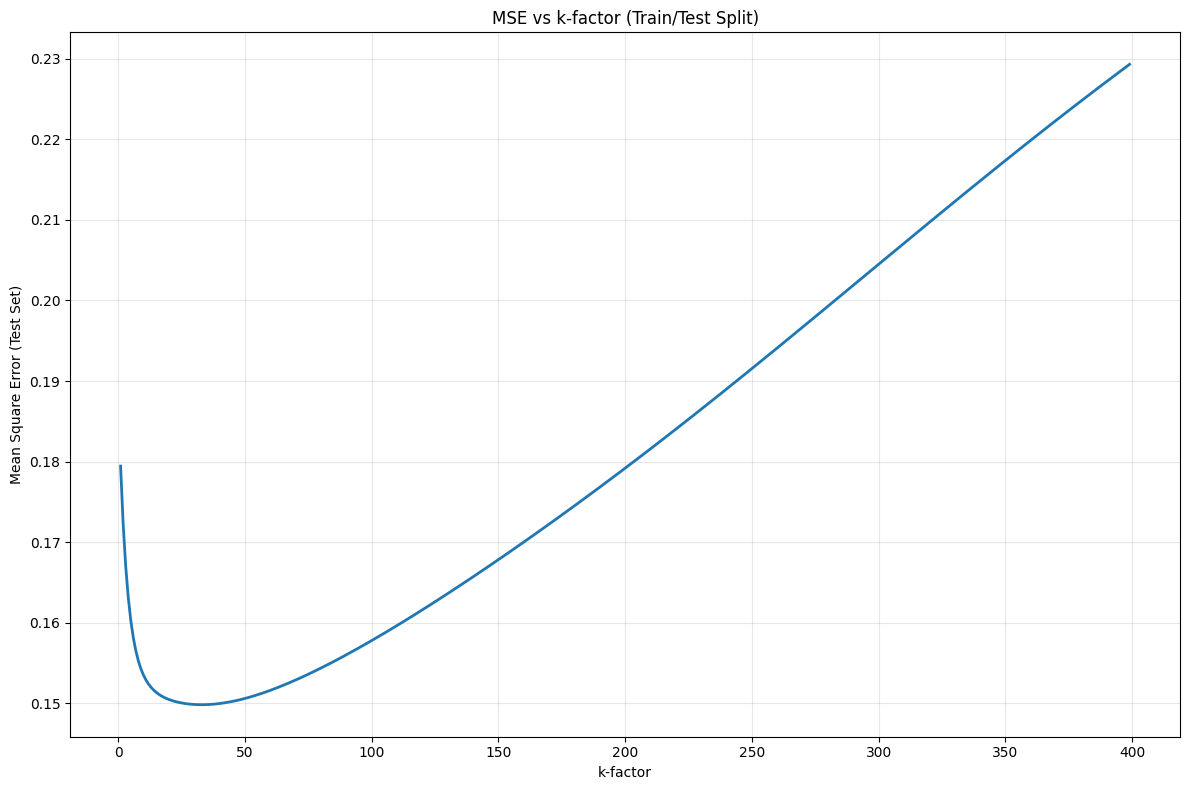


 The Optimal k - factor is: 33.000 with MSE = 0.149850


In [11]:
plt.figure(figsize=(12, 8))
plt.plot(k_values, mse_values, linewidth=2)
plt.xlabel("k-factor")
plt.ylabel("Mean Square Error (Test Set)")
plt.title("MSE vs k-factor (Train/Test Split)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

optimal_k = k_values[mse_values.index(min(mse_values))]
print(f"\n The Optimal k - factor is: {optimal_k:.3f} with MSE = {min(mse_values):.6f}")

#### $$\textbf{Analysis}$$

The U-shaped graph shows a clear non-monotonic relationship between the Elo $k$-factor and the mean squared error (MSE) on the held-out test set. For very small values of $k$, the MSE is relatively high, indicating the ratings change too slowly during training and therefore fail to capture meaningful differences in team strength. As $k$ increases, the model becomes more responsive to match outcomes, leading to a rapid decrease in test error.

The MSE reaches its minimum at $k = 33$ with a value of 0.149850. Beyond this point, the error increases steadily as $k$ grows, suggesting that the ratings react too strongly to individual results, causing them to encode noise from the training data.


In [12]:
def create_team_colour_mapping() -> dict[str, str]:
    """
    Creates a consistent colour mapping for all teams across multiple seasons using custom hex colours
    
    :param all_timeseries: list of timeseries dictionaries from different seasons
    
    :returns: dictionary mapping team names to colour hex codes
    """

    all_teams = sorted(df["HomeTeam"].unique().tolist())

    colours = [
        '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
        '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4',
        '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000',
        '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9',
        '#ff6b6b', '#4ecdc4', '#45b7d1', '#f7b731', '#5f27cd',
    ]
    
    team_colours = {}
    for i in range(len(all_teams)):
        team = all_teams[i]
        team_colours[team] = colours[i]
    
    return team_colours


def plot_elo_timeseries_combined(
    timeseries_list: list[dict[str, dict[datetime, float]]],
    season_ranges: list[tuple[datetime, datetime]]
) -> None:
    """
    Plots Elo timeseries for multiple seasons in a 2x2 subplot grid,
    with all teams on each subplot and consistent colours across all plots
    
    :param timeseries_list: list of 4 timeseries dictionaries (one per season)
    :param season_ranges: list of 4 tuples containing (start_date, end_date) for each season
    
    :returns: None
    """
    if len(timeseries_list) != 4 or len(season_ranges) != 4:
        raise Exception("This function requires exactly 4 seasons")
    
    team_colours = create_team_colour_mapping()
    
    # Find global y-axis boundaries across all seasons
    global_min = 1500
    global_max = 1500
    for timeseries in timeseries_list:
        for team_data in timeseries.values():
            values = list(team_data.values())
            # the min/max function selects the smallest/largest value of the values passed to it
            local_min = min(values)
            local_max = max(values)
            global_min = min(global_min, local_min)
            global_max = max(global_max, local_max)
    
    # Round to nearest 10 +/- 5 for margins so that the line doesn't touch the boundaries
    min_y = (math.floor(global_min / 10) * 10) - 5
    max_y = (math.ceil(global_max / 10) * 10) + 5
    

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    axes = axes.flatten()
    
    # Track which teams we've plotted for the legend (should be all)
    # we use a set to automatically eliminate duplicates
    all_plotted_teams = set()
    
    # we already checked that we passed exactly 4 seasons and their corresponding data
    for i in range(4):
        timeseries = timeseries_list[i]
        (s_start, s_end) = season_ranges[i]

        teams = sorted(list(timeseries.keys()))
        
        for team in teams:
            date_values = timeseries[team]
            dates = sorted(list(date_values.keys()))

            values = []
            for date in dates:
                values.append(date_values[date])
            
            axes[i].plot(
                dates, 
                values, 
                linewidth=1.5, 
                color=team_colours[team],
                label=team,
                alpha=0.7
            )
            
            # track that we have plotted this team
            all_plotted_teams.add(team)
        
        axes[i].set_xlabel('Date', fontsize=10)
        axes[i].set_ylabel('Elo Rating', fontsize=10)
        axes[i].set_title(f'Elo Changes ({s_start.year}-{s_end.year})', fontsize=12)
        axes[i].set_ylim(min_y, max_y)
        axes[i].grid(alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].tick_params(axis='y', labelsize=8)
    
    sorted_plotted_teams = sorted(list(all_plotted_teams))
    # for each of the teams we know we plotted, in order to have them appear in the legend
    # rather than trying to keep track of which plot each team appears in
    # we can create fake lines that we never draw and give them the correct colours and labels
    legend_handles = []
    for team in sorted_plotted_teams:
        fake_line = plt.Line2D([0], [0], color=team_colours[team], linewidth=2, label=team)
        legend_handles.append(fake_line)

    
    fig.legend(
        handles=legend_handles,
        loc='center left',
        bbox_to_anchor=(1.0, 0.5),
        fontsize=15,
        ncol=1
    )
    
    fig.suptitle('Elo Rating Evolution Across Seasons', fontsize=18, y=0.95)
    fig.tight_layout(rect=[0, 0, 0.92, 0.96])
    plt.show()

### $$\textbf{Evolution of Elo Over Time per Team}$$

The figure below summarises the seasonal evolution of Elo ratings for all teams across four seasons, with each season initialised at a common baseline of 1500 and updated sequentially after each match. Because the Elo update is applied symmetrically (the home team gains $\Delta E$ while the away team loses $\Delta E$), the ratings in each panel should be interpreted as relative team strength within that season. Consistent upward trends indicate repeated overperformance whereas consistent downward trends indicate repeated underperformance.

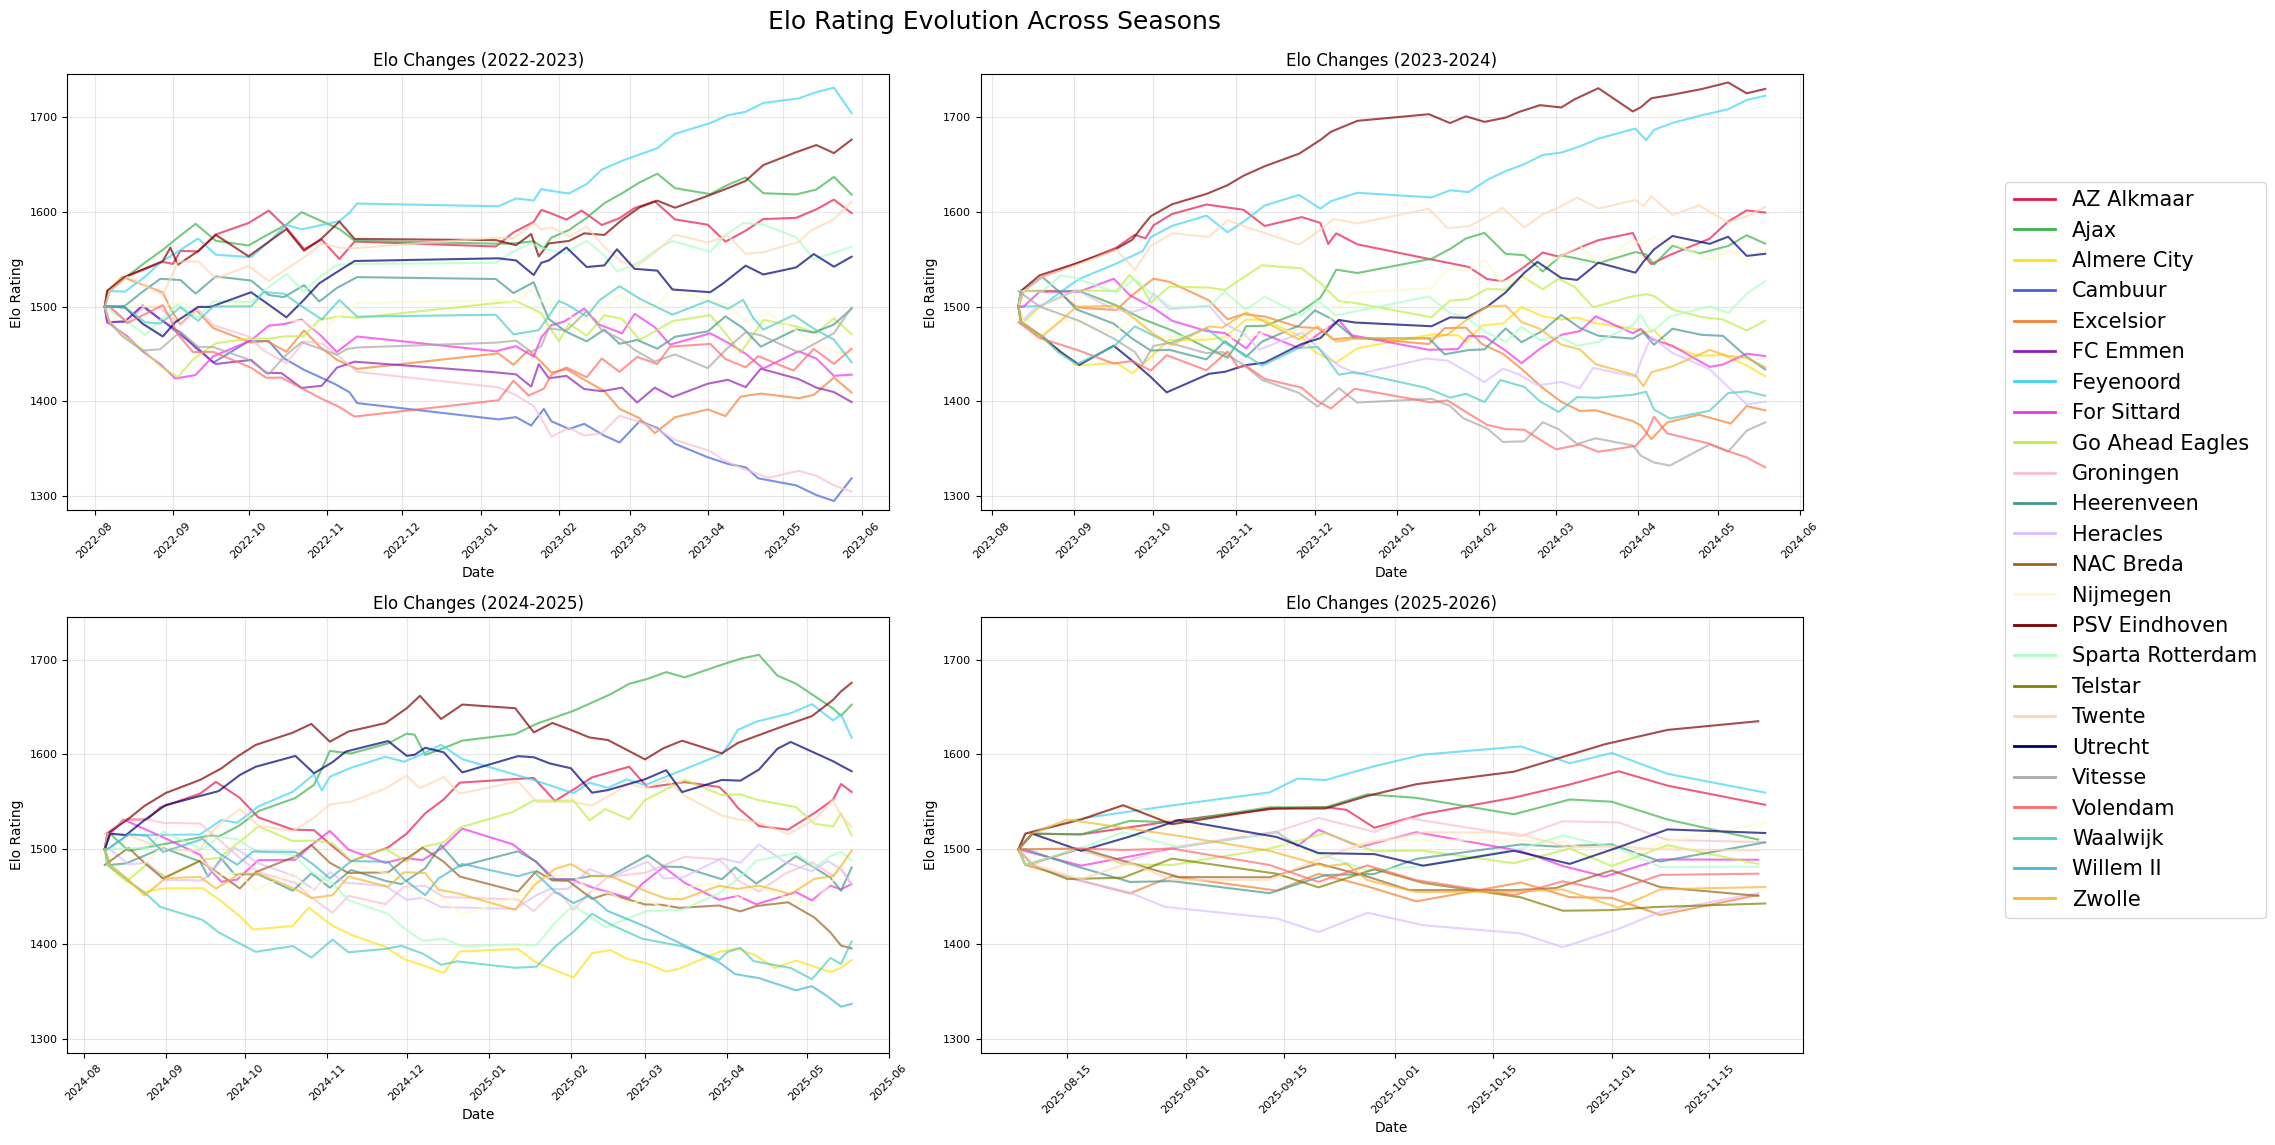

In [13]:
plot_elo_timeseries_combined(
    timeseries_list=[
        elos_2022_timeseries,
        elos_2023_timeseries,
        elos_2024_timeseries,
        elos_2025_timeseries,
    ],
    season_ranges=[
        (Y_2022_START, Y_2022_END),
        (Y_2023_START, Y_2023_END),
        (Y_2024_START, Y_2024_END),
        (Y_2025_START, Y_2025_END),
    ]
)

##### $$\textbf{Analysis}$$

In 2022–2023, ratings separate quickly from the common baseline and end with a large spread, indicating that match results carried a strong and persistent signal of relative team strength. Feyenoord exhibits the dominant upward trajectory, reaching the highest rating by late season, while PSV Eindhoven and Ajax also sit at a higher position but remain clearly below Feyenoord's peak. At the opposite extreme, Cambuur shows a pronounced and largely monotone decline that reaches the lowest rating amongst all clubs, consistent with repeated underperformance relative to expectations. A clear plateau around mid-season is visible across many teams; this matches the league break (14 November to 5 January), during which no matches are played and Elo values remain unchanged.

In 2023–2024, the top of the distribution is even more clearly defined: PSV Eindhoven rises steadily and finishes as the highest-rated team, while Feyenoord follows as a clear second exhibiting a constant positive trend. Below the top two, many clubs remain in a relatively narrow mid-band and show more oscillatory behaviour, with multiple crossings that reflect local re-ordering. At the lower end, the weakest trajectories fall into the mid-1300s to low-1400s range, suggesting that poor performance was not limited to isolated matches but persisted across substantial parts of the season.

In 2024–2025, the season shows a competitive top group with visible shifts in the highest rated team over time. Ajax reaches the highest levels in the later phases of the season but also exhibits a noticeable late drop. PSV Eindhoven stays in the upper zone throughout, and Feyenoord trends upward later in the season. The lower tail again includes teams with sustained declines (with the lowest lines approaching the mid-1300s), while the middle group remains relatively dense and marked by frequent crossings, consistent with a season where many clubs alternate between outperforming and underperforming expectation.

In 2025–2026, the spread is much smaller and the curves remain closer to 1500 overall, which is consistent with the season being incomplete: fewer matches implies fewer updates and less opportunity for ratings to diverge. Even within this partial sample, PSV Eindhoven already shows the strongest upward drift and sits at the top of the panel, while most other teams occupy a compressed zone with modest positive or negative movement. Because early-season ratings are highly sentitive to noise the differences visible here are best treated as early signals rather than stable conclusions.

Because ratings are reset to 1500 at the start of each season, the sublots are not directly comparable: the graphs describe within-season ranking dynamics rather than multi-year strength tracking and so the plotted values are best understood as within-season relative strength estimates. Second, with the use of the optimal $k$-factor, Elo ratings change mainly when a team produces consistent results over several matches. Teams that repeatedly perform above or below expectation move steadily up or down respectively, whereas teams with mixed results tend to stay closer together and change rank more often.
 

#### $$\textbf{Takeaway}$$
Taken together, the outcome counts, goal totals, and Elo trajectories provide a consistent picture of the league structure across seasons. At the top end, PSV Eindhoven and Feyenoord repeatedly emerge as the most dominant teams, with PSV distinguished by constant attacking power and win volume. At the opposite end, the same teams that accumulate high loss totals and low goal totals also tend to exhibit persistent Elo decline, indicating that underperformance is not episodic but often sustained across long periods of time. Both the win/draw/loss distributions and the Elo plots suggest a comparatively dense and fluid structure in which local re-orderings occur frequently, while draws remain relatively stable and therefore contribute less to separating teams than win conversion and loss avoidance. Finally, the repeated home-away asymmetry in results supports a league-wide home advantage, whereas goal splits show more team-specific venue dependence; and because 2025–2026 is incomplete, the corresponding patterns should be treated as preliminary trends rather than absolute conclusions.

## $$\textbf{PART 3: OFFENSIVE-DEFENSIVE ELO RATING MODEL}$$


#### $$\textbf{Creating the Model}$$

This model refines the standard Elo framework by separating team strength into two components: an offensive rating, intended to capture a team's ability to score goals, and a defensive rating, intended to capture a team's ability to prevent goals. 

In the offensive–defensive Elo model, rating updates are applied to two components per team and remain symmetric at the level of each component: after each match, the offensive and defensive Elo ratings of both teams are updated based on deviations between observed and expected goals, with all teams initialised at 1500 for both ratings and updated sequentially over the specified time period.

For a given match with home team $\text{H}$ and away team $\text{A}$ the offensive and defensive updates are:

$$
\Delta E^{\text{off}}_{\text{H}} = k_{\text{off}} \cdot (G^{\text{actual}}_{\text{H}} - G^{\text{expected}}_{\text{H}})
$$, 

$$
\Delta E^{\text{off}}_{\text{A}} = k_{\text{off}} \cdot (G^{\text{actual}}_{\text{A}} - G^{\text{expected}}_{\text{A}})
$$, 

$$
\Delta E^{\text{def}}_{\text{H}} = k_{\text{def}} \cdot (G^{\text{expected}}_{\text{A}} - G^{\text{actual}}_{\text{A}})
$$, 

$$
\Delta E^{\text{def}}_{\text{A}} = k_{\text{def}} \cdot (G^{\text{expected}}_{\text{H}} - G^{\text{actual}}_{\text{H}})
$$,

where $k_{\text{off}}, \ k_{\text{def}}$ are scaling factors and $G^{\text{actual}}, G^{\text{expected}}$ are the observed and expected goals respectively; in the defensive update $G^{\text{actual}}$ refers to goals conceded.

The expected number of goals is given by:

$$
G_{\text{H}}^{\text{expected}}= \mu \times 10^{\frac{E^{\text{off}}_{\text{H}} - E^{\text{def}}_{\text{A}}}{400}}
$$,

$$
G_{\text{A}}^{\text{expected}}= \mu \times 10^{\frac{E^{\text{off}}_{\text{A}} - E^{\text{def}}_{\text{H}}}{400}}
$$,

where $\mu$ is the mean number of goals per team per match.






In [14]:
# we find the mean number of goals scored throughout all matches
mean = (df["FTHG"].mean() + df["FTAG"].mean()) / 2
#print(mean)

In [15]:
def expected_goals(offensive_elo_team_A: float, defensive_elo_team_B: float) -> float:
    """
    Computes the expected number of goals team A will score during this match

    :param offensive_elo_team_A: float team A's offensive Elo
    :param defensive_elo_team_B: float team B's defensive Elo

    :returns: float the expected number of goals
    """
    return mean * (10 ** ((offensive_elo_team_A - defensive_elo_team_B) / 400))


def delta_change_off(actual_goals: int, expected_goals: float, k_off: float) -> float:
    """
    Computes the delta for updating the offensive Elo of a team

    :param actual_goals: int the number of goals actually scored by a team in the match
    :param expected_goals: float the number of goals our model predicts the team will score
    :param k_off: float the k-factor
    
    :returns: float the change in offensive Elo for this team
    """
    return k_off * (actual_goals - expected_goals)


def delta_change_def(actual_goals: int, expected_goals: float, k_def: float) -> float:
    """
    Computes the delta for updating the defensive Elo of a team

    :param actual_goals: int the number of goals the team conceded during the match
    :param expected_goals: float the number of goals our model predicts the team will concede
    :param k_off: float the k-factor
    
    :returns: float the change in defensive Elo for this team    
    """
    return k_def * (expected_goals - actual_goals)





def simulate_with_split_elos(s_start: datetime, s_end: datetime, k_off: float, k_def: float) -> tuple[dict[str, dict[str, float]], dict[str, dict[str, dict[datetime, float]]]]:
    """
    Simulates how each match of a season would update the offensive and defensive Elo of a team after every match

    :param s_start: datetime the start date of this season
    :param s_end: datetime the end date of this season
    :param k_off: float the k-factor for the offensive elo delta change
    :param k_def: float the k-factor for the defensive elo delta change

    :returns: a pair of dictionaries, \
        the first is a dictionary which maps teams to another \
        dictionary storing the offensive and defensive elo for that team, \
        the second is a dictionary mapping teams to another dictionary \
        storing the offensive and defensive timeseries data as dictionaries \
        with keys as datetimes and values the elos which are just floats

    """
    # this code is very similar to the simulation code above, 
    # with the exception of the timeseries dictionary having an additional level of depth
    season_df = df[(df["Date"] >= s_start) & (df["Date"] <= s_end)]
    
    all_teams = season_df["HomeTeam"].unique()
    
    elos = {}
    for team in all_teams:
        elos[team] = {
            "defensive" : 1500,
            "offensive" : 1500
        }


    #   {
    #       "Volendam": {
    #           "offensive": {
    #               "2023-08-11" : 1500.0,
    #               "2023-08-19" : 1498.0,
    #               ...
    #           },
    #           "defensive": {
    #               "2023-08-11" : 1500.0,
    #               "2023-08-19" : 1498.0,
    #               ...
    #           }
    #       },
    #       "Vitesse": {
    #           "offensive": {
    #               "2023-08-11" : 1500.0,
    #               "2023-08-19" : 1498.0,
    #               ...
    #           },
    #           "defensive": {
    #               "2023-08-11" : 1500.0,
    #               "2023-08-19" : 1498.0,
    #               ...
    #           }
    #       },
    #       ...
    #   }
    elos_timeseries = {}
    for team in all_teams:
        elos_timeseries[team] = {
            "defensive" : { s_start : 1500 },
            "offensive" : { s_start : 1500 }
        }
        

    season_df = season_df.sort_values('Date')


    for (_, row) in season_df.iterrows(): 
        home = row["HomeTeam"]
        away = row["AwayTeam"]
        date = row["Date"]

        actual_goals_home = row["FTHG"]
        actual_goals_away = row["FTAG"]

        elo_home_off = elos[home]["offensive"]
        elo_home_def = elos[home]["defensive"]
        elo_away_off = elos[away]["offensive"]
        elo_away_def = elos[away]["defensive"]
        
        expected_goals_home = expected_goals(elo_home_off, elo_away_def)
        expected_goals_away = expected_goals(elo_away_off, elo_home_def)


        # Home team's offense: how many goals did they score vs expected?
        elos[home]["offensive"] += delta_change_off(actual_goals_home, expected_goals_home, k_off) # m * (2 - 1.5) = m * 0.5

        # Home team's defense: how many goals did they concede vs expected?
        elos[home]["defensive"] += delta_change_def(actual_goals_away, expected_goals_away, k_def) # m * (1 - 1.5) = m * (-0.5)


        # Away team's offense: how many goals did they score vs expected?
        elos[away]["offensive"] += delta_change_off(actual_goals_away, expected_goals_away, k_off) # n * (1.5 - 1) = n * 0.5

        # Away team's defense: how many goals did they concede vs expected? (expected to concede 1.5, conceded 2)
        elos[away]["defensive"] += delta_change_def(actual_goals_home, expected_goals_home, k_def) # n * (1.5 - 2) = n * (-0.5)

        elos_timeseries[home]["offensive"][date] = elos[home]["offensive"]
        elos_timeseries[home]["defensive"][date] = elos[home]["defensive"]
        elos_timeseries[away]["offensive"][date] = elos[away]["offensive"]
        elos_timeseries[away]["defensive"][date] = elos[away]["defensive"]


    return (elos, elos_timeseries)

#### $$\textbf{Fitting the parameters } k_{\text{off}} \textbf{ and } k_{\text{def}}$$


This section studies how the Elo model's performance depends on the updated parameters $k_{\text{off}}$ and $k_{\text{def}}$. To determine an appropriate value, historical data from previous seasons is used to evaluate the Mean Squared Error (MSE) by searching over a grid of $\left(k_{\text{off}}, k_{\text{def}}\right)$ pairs. The optimal defensive and offensive $k$-factors are then identified as the values that minimise the test-set error.

Ratings are fitted on a training period and then evaluated on a separate test period using the mean squared error (MSE) between the observed goals and the corresponding model predictions for both the home and away team.

The Mean Squared Error (MSE) over the test-set is computed as:

$$
\frac{1}{2|M|}\sum\limits_{m \in M}\left[(G^{\text{actual}}_{\text{H}}(m) - G^{\text{expected}}_{\text{H}}(m))^2 + (G^{\text{actual}}_{\text{A}}(m) - G^{\text{expected}}_{\text{A}}(m))^2\right]
$$,

where $M$ denotes the set of test matches.

In [16]:
def train_split_elos(train_start: datetime, train_end: datetime, k_off: float, k_def: float) -> dict[str, dict[str, float]]:
    """
    :param train_start: datetime the start date of the training data
    :param train_end: datetime the end date of the training data
    :param k_off: float the k-factor for the offensive elo delta change
    :param k_def: float the k-factor for the defensive elo delta change
    
    :returns: a dictionary which maps teams to another dictionary storing the offensive and defensive elo for that team
    """
    train_df = df[(df["Date"] >= train_start) & (df["Date"] <= train_end)].sort_values("Date")
    all_teams = df["HomeTeam"].unique()


    elos = {}
    for team in all_teams:
        elos[team] = {
            "defensive" : 1500,
            "offensive" : 1500
    }

    for (_, row) in train_df.iterrows():
        home = row["HomeTeam"]
        away = row["AwayTeam"]
        goals_home = int(row["FTHG"])
        goals_away = int(row["FTAG"])

        expected_home_goals = expected_goals(elos[home]["offensive"], elos[away]["defensive"])
        expected_away_goals = expected_goals(elos[away]["offensive"], elos[home]["defensive"])

        elos[home]["offensive"] += delta_change_off(goals_home, expected_home_goals, k_off)
        elos[home]["defensive"] += delta_change_def(goals_away, expected_away_goals, k_def)

        elos[away]["offensive"] += delta_change_off(goals_away, expected_away_goals, k_off)
        elos[away]["defensive"] += delta_change_def(goals_home, expected_home_goals, k_def)

    return elos


def mse_goals_on_test(test_start: datetime, test_end: datetime, elos: dict[str, dict[str, float]]) -> float:
    """
    :param test_start: datetime the start date of the testing data
    :param test_end: datetime the end date of the testing data
    :param elos: a dictionary which maps teams to another dictionary storing the offensive and defensive elo for that team
    
    :returns: float the MSE
    """
    test_df = df[(df["Date"] >= test_start) & (df["Date"] <= test_end)].sort_values("Date")

    total_errors = 0
    n = 0

    for (_, row) in test_df.iterrows():
        home = row["HomeTeam"]
        away = row["AwayTeam"]
        goals_home = int(row["FTHG"])
        goals_away = int(row["FTAG"])

        elo_home = elos[home]
        elo_away = elos[away]

        pred_home = expected_goals(elo_home["offensive"], elo_away["defensive"])
        pred_away = expected_goals(elo_away["offensive"], elo_home["defensive"])

        total_errors += (goals_home - pred_home) ** 2 + (goals_away - pred_away) ** 2
        n += 1 

    return total_errors / (2 * n)


def run_mse_with_split_goals(train_start: datetime, train_end: datetime, test_start: datetime, test_end: datetime, k_off: float, k_def: float) -> float:
    """
    :param train_start: datetime the start date of the training data
    :param train_end: datetime the end date of the training data
    :param test_start: datetime the start date of the testing data
    :param test_end: datetime the end date of the testing data
    :param k_off: float the k-factor for the offensive elo delta change
    :param k_def: float the k-factor for the defensive elo delta change
    :param elos: a dictionary which maps teams to another dictionary storing the offensive and defensive elo for that team
    
    :returns: float the MSE
    """
    elos = train_split_elos(train_start, train_end, k_off, k_def)
    return mse_goals_on_test(test_start, test_end, elos)


optimal_k_off = 0
optimal_k_def = 0
# we set the mse to positive infinity, that way we can be sure that whatever MSE we compute, will be lower
lowest_mse = float("inf")

for k_off in range(0, 61, 2):
    for k_def in range(0, 61, 2):
        mse = run_mse_with_split_goals(
            Y_2022_START, Y_2024_END,
            Y_2024_START, Y_2025_END,
            k_off, k_def
        )
        if mse < lowest_mse:
            optimal_k_off = k_off
            optimal_k_def = k_def
            lowest_mse = mse

print(f"\n The optimal (k_off, k_def) = ({optimal_k_off}, {optimal_k_def}) with MSE = {lowest_mse:.6f}")


 The optimal (k_off, k_def) = (6, 2) with MSE = 1.494649


In [17]:
(y2022_elos_split, y2022_elos_timeseries_split) = simulate_with_split_elos(Y_2022_START, Y_2022_END, k_off=optimal_k_off, k_def=optimal_k_def)
(y2023_elos_split, y2023_elos_timeseries_split) = simulate_with_split_elos(Y_2023_START, Y_2023_END, k_off=optimal_k_off, k_def=optimal_k_def)
(y2024_elos_split, y2024_elos_timeseries_split) = simulate_with_split_elos(Y_2024_START, Y_2024_END, k_off=optimal_k_off, k_def=optimal_k_def)
(y2025_elos_split, y2025_elos_timeseries_split) = simulate_with_split_elos(Y_2025_START, Y_2025_END, k_off=optimal_k_off, k_def=optimal_k_def)

In [18]:
def plot_team_profiles_combined(
    elos_list: list[dict[str, dict[str, float]]], 
    season_ranges: list[tuple[datetime, datetime]]
) -> None:
    """
    Plots the offensive vs defensive Elos for each team across multiple seasons in a 2x2 subplot

    :param elos_list: list of dictionaries mapping team names to another dictionary which stores the offensive and defensive elos
    :param season_ranges: list of tuples containing (start_date, end_date) for each season

    :returns: None
    """
    if len(elos_list) != 4 or len(season_ranges) != 4:
        raise Exception("This function requires exactly 4 seasons")
    

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    axes = axes.flatten()
    
    for i in range(4):
        elos = elos_list[i]
        (s_start, s_end) = season_ranges[i]
        
        all_teams = list(elos.keys())
        
        offensive_elos = []
        defensive_elos = []
        for team in all_teams:
            offensive_elos.append(elos[team]["offensive"])
            defensive_elos.append(elos[team]["defensive"])
        
        axes[i].scatter(defensive_elos, offensive_elos, s=40, alpha=0.5, color="#3b82f6")
        
        for j in range(len(all_teams)):
            axes[i].annotate(all_teams[j], (defensive_elos[j], offensive_elos[j]), fontsize=8)
        
        # Add quadrant lines
        axes[i].axhline(y=1500, color='gray', linestyle='--', alpha=0.3)
        axes[i].axvline(x=1500, color='gray', linestyle='--', alpha=0.3)
        
        axes[i].set_xlabel('Defensive Elo')
        axes[i].set_ylabel('Offensive Elo')
        axes[i].set_title(f'Offensive vs Defensive Strength ({s_start.year}-{s_end.year})')
        axes[i].grid(alpha=0.3)
    
    fig.tight_layout()
    plt.show()



#### $$\textbf{Offensive vs Defensive Strength per Team per Season}$$

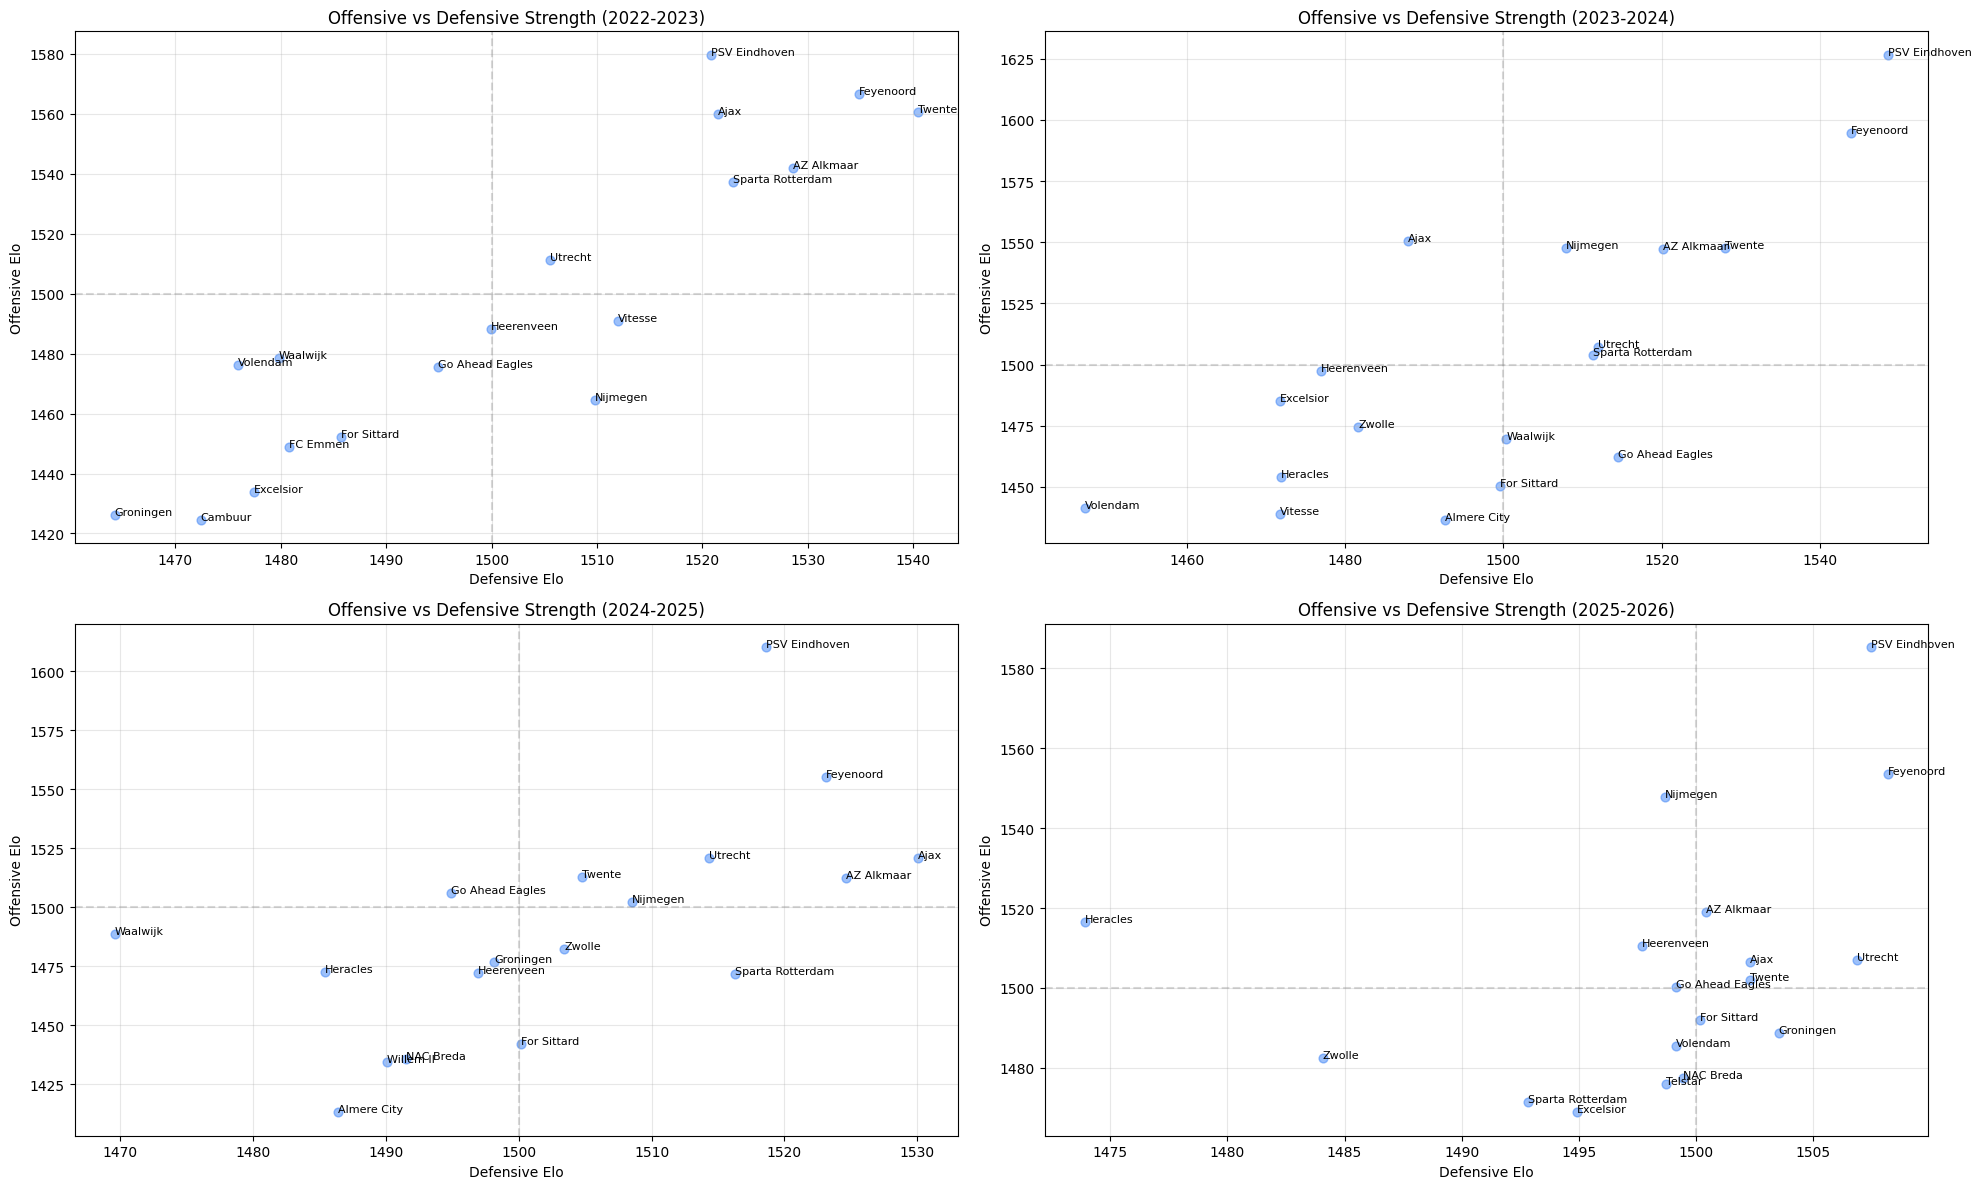

In [19]:
plot_team_profiles_combined(
    elos_list=[y2022_elos_split, y2023_elos_split, y2024_elos_split, y2025_elos_split],
    season_ranges=[
        (Y_2022_START, Y_2022_END),
        (Y_2023_START, Y_2023_END),
        (Y_2024_START, Y_2024_END),
        (Y_2025_START, Y_2025_END)
    ]
)

#### $$\textbf{Analysis}$$

In 2022–2023, the offensive–defensive strength plane exhibits a clear stratification around the (1500,1500) reference lines. A small group of teams lies in the upper-right quadrant, indicating simultaneously above-average offensive strength and above-average defensive suppression under the model; this group includes PSV Eindhoven, Feyenoord, Ajax, Twente, Sparta Rotterdam and AZ Alkmaar, with PSV Eindhoven showing the highest offensive Elo in the panel. Several teams sit close to the horizontal or vertical reference lines, suggesting more balanced profiles in which either attacking output or defensive performance is near the league baseline; as an example Utrecht is slightly above both baselines, whereas Heerenveen and Vitesse are closer to baseline defensively but below average offensively. The lower-left quadrant contains multiple teams with both offensive and defensive Elo below 1500, notably including Cambuur, Excelsior and Groningen.

In 2023–2024, the model places PSV Eindhoven as the dominant outlier in the upper-right quadrant, combining the highest offensive Elo with a the highest defensive Elo, which indicates consistent overperformance in goal scoring and goal prevention relative to expectations. Feyenoord forms the next strongest profile, also strongly in the upper-right region. A number of teams cluster in the mid-to-upper band of defensive Elo with more moderate offensive Elo (e.g., Utrecht and Sparta Rotterdam), indicating teams that are relatively well-balanced yet not extreme in either dimension. A distinct feature of this season is the presence of asymmetric profiles, such as Ajax appearing in the upper-left quadrant (high offensive Elo with defensive Elo below the baseline), which is consistent with strong attacking output paired with weaker goal prevention relative to expectation. At the lower end, teams such as Volendam are at the bottom-left region, indicating weakness in both dimensions.

In 2024–2025, the upper-right quadrant again contains a compact top group, with PSV Eindhoven attaining the highest offensive Elo and maintaining an above-baseline defensive Elo, while Feyenoord and Ajax also remain in the region of jointly strong offense and defense. Several teams lie close to the reference lines, indicating near-baseline behaviour in one component and modest deviations in the other (for example, Nijmegen and Twente sit slightly above the offensive baseline with defensive values close to or moderately above 1500). A noteworthy defensive–offensive imbalance appears for Sparta Rotterdam, which lies to the right of the defensive baseline but below the offensive baseline, consistent with a defence-first profile that concedes less than expected but scores less than expected. The lower-left region includes teams such as Almere City, whose low offensive Elo indicates persistent underperformance in scoring relative to the model's goal expectation.

In 2025–2026, there is an accumulation of poins tightly concentrated around (1500,1500), which is expected because the season is incomplete and therefore provides fewer matches from which the offensive and defensive components can separate. The locations in this panel should not be read as absolute, final estimates of team quality rather they are early indicators that can shift as more data accumulates. Even within this partial sample, PSV Eindhoven and Feyenoord appear as clear upper-right profiles indicating early evidence of strong attacking output and solid goal prevention relative to expectation, while Nijmegen sits notably high on the offensive axis with defensive Elo near baseline, suggesting an attack-driven profile so far. Many other teams remain close to the reference lines implying that their observed scoring and concession are still near the model's baseline expectation.

Overall, these scatter plots provide a compact season-level summary of each team's "style" under the model by separating attacking and defensive Elos: positions above or right to the 1500 reference lines indicate systematic overperformance in scoring relative to the expected-goals mechanism while positions below or left to the 1500 reference lines indicate the opposite. Teams in the upper-right quadrant represent the most balanced high-performing profiles, whereas upper-left or lower-right locations represent more one-sided profiles in which strength is concentrated in a single component.

#### $$\textbf{Takeaway}$$

Taken together, the offensive–defensive scatter plots reinforce the broader picture obtained from outcomes, goal totals, and Elo time series: PSV Eindhoven and Feyenoord consistently separates from the league by combining strong scoring and strong goal prevention , while the lower-performing teams (Cambuur, Excelsior, Groningen, Volendam, Almere City, and Vitesse) tend to sit below baseline in both components, matching their higher loss counts, weaker goal output, and sustained rating decline.  Most remaining clubs cluster close to the (1500,1500) reference lines, indicating that mid-group teams often differ only modestly and can shift between attack-leaning and defence-leaning profiles over short periods. The recurring home–away asymmetry in results is compatible with this structure, but the offensive–defensive decomposition suggests that venue effects do not translate into a single uniform scoring pattern across clubs. Finally, because 2025–2026 is incomplete, its positions should be interpreted as provisional: the same diagnostics already appear, but the separation between teams is expected to stabilise and potentially reorder as more matches are played.

In [20]:
def plot_all_teams_combined_split_elos(
    timeseries_list: list[dict[str, dict[str, dict[datetime, float]]]],
    season_ranges: list[tuple[datetime, datetime]]
) -> None:
    """
    Plots all teams' offensive and defensive Elo timeseries in 8 subplots.
    Each season has 2 subplots: one for offensive Elo and one for defensive Elo.
    All teams are plotted with consistent colors from the team color mapping.

    :param timeseries_list: list of 4 timeseries dictionaries (one per season)
    :param season_ranges: list of 4 tuples containing (start_date, end_date) for each season

    :returns: None
    """
    if len(timeseries_list) != 4 or len(season_ranges) != 4:
        raise Exception("This function requires exactly 4 seasons")

    team_colours = create_team_colour_mapping()

    global_min = 1500
    global_max = 1500
    for timeseries in timeseries_list:
        for team_data in timeseries.values():
            offensive_values = list(team_data["offensive"].values())
            defensive_values = list(team_data["defensive"].values())
            all_values = offensive_values + defensive_values
            local_min = min(all_values)
            local_max = max(all_values)
            global_min = min(global_min, local_min)
            global_max = max(global_max, local_max)

    min_y = (math.floor(global_min / 10) * 10) - 5
    max_y = (math.ceil(global_max / 10) * 10) + 5

    # Create 4 rows x 2 columns = 8 subplots
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 24))

    all_plotted_teams = set()

    for i in range(4):
        timeseries = timeseries_list[i]
        (s_start, s_end) = season_ranges[i]

        teams = sorted(list(timeseries.keys()))

        # offensive Elo in left column (column 0)
        for team in teams:
            offensive_timeseries = timeseries[team]["offensive"]
            dates = sorted(list(offensive_timeseries.keys()))
            
            offensive_values = []
            for date in dates:
                offensive_values.append(offensive_timeseries[date])

            axes[i, 0].plot(
                dates,
                offensive_values,
                linewidth=1.5,
                color=team_colours[team],
                alpha=0.7
            )

            all_plotted_teams.add(team)

        axes[i, 0].set_xlabel('Date', fontsize=10)
        axes[i, 0].set_ylabel('Offensive Elo Rating', fontsize=10)
        axes[i, 0].set_title(f'Offensive Elo ({s_start.year}-{s_end.year})', fontsize=12)
        axes[i, 0].set_ylim(min_y, max_y)
        axes[i, 0].grid(alpha=0.3)
        axes[i, 0].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i, 0].tick_params(axis='y', labelsize=8)

        # defensive Elo in right column (column 1)
        for team in teams:
            defensive_timeseries = timeseries[team]["defensive"]
            dates = sorted(list(defensive_timeseries.keys()))

            defensive_values = []
            for date in dates:
                defensive_values.append(defensive_timeseries[date])

            axes[i, 1].plot(
                dates,
                defensive_values,
                linewidth=1.5,
                color=team_colours[team],
                alpha=0.7
            )

        axes[i, 1].set_xlabel('Date', fontsize=10)
        axes[i, 1].set_ylabel('Defensive Elo Rating', fontsize=10)
        axes[i, 1].set_title(f'Defensive Elo ({s_start.year}-{s_end.year})', fontsize=12)
        axes[i, 1].set_ylim(min_y, max_y)
        axes[i, 1].grid(alpha=0.3)
        axes[i, 1].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i, 1].tick_params(axis='y', labelsize=8)

    sorted_plotted_teams = sorted(list(all_plotted_teams))

    legend_handles = []
    for team in sorted_plotted_teams:
        fake_line = plt.Line2D([0], [0], color=team_colours[team], linewidth=2, label=team)
        legend_handles.append(fake_line)

    fig.legend(
        handles=legend_handles,
        loc='center left',
        bbox_to_anchor=(1.0, 0.5),
        fontsize=25,
        ncol=1
    )

    fig.suptitle('Offensive and Defensive Elo Evolution Across Seasons', fontsize=18, y=0.995)
    fig.tight_layout(rect=[0, 0, 0.92, 0.99])
    plt.show()

#### $$\textbf{Offensive and Defensive Elo Evolution Across Seasons}$$

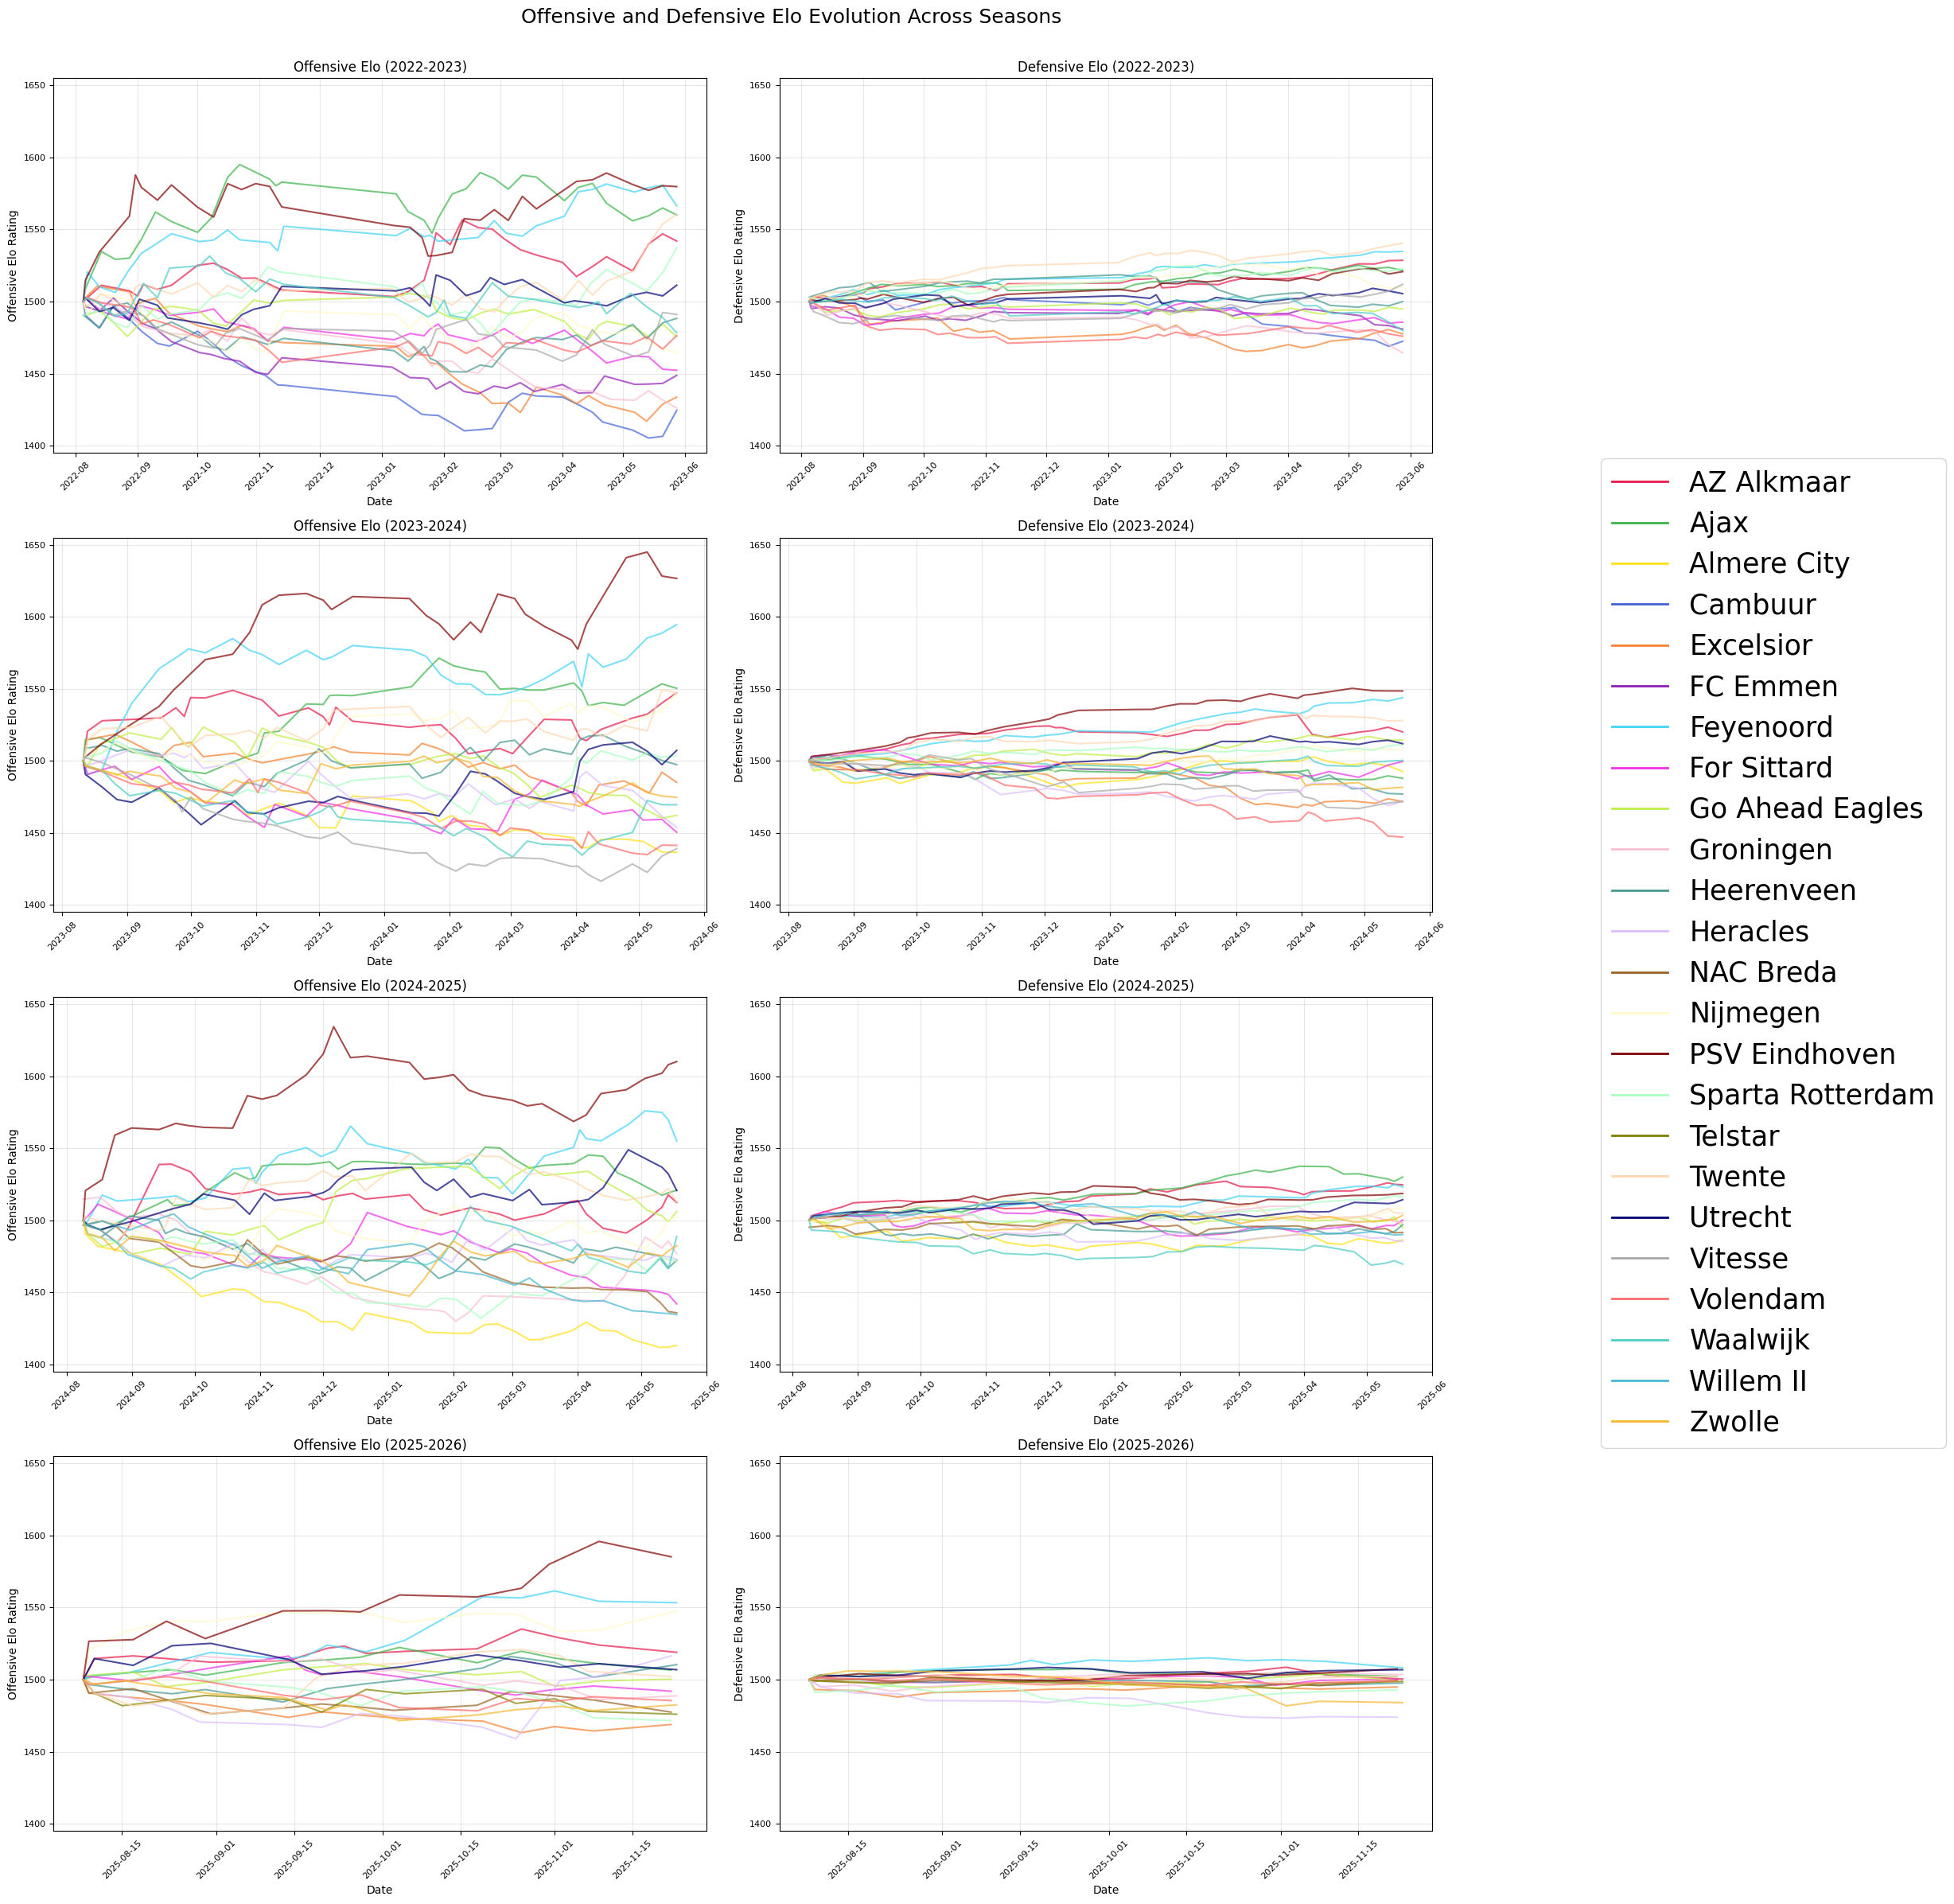

In [21]:
plot_all_teams_combined_split_elos(
    timeseries_list=[
        y2022_elos_timeseries_split,
        y2023_elos_timeseries_split,
        y2024_elos_timeseries_split,
        y2025_elos_timeseries_split,
    ],
    season_ranges=[
        (Y_2022_START, Y_2022_END),
        (Y_2023_START, Y_2023_END),
        (Y_2024_START, Y_2024_END),
        (Y_2025_START, Y_2025_END),
    ]
)

#### $$\textbf{Analysis}$$

In 2022–2023, the offensive Elo trajectories separate relatively quickly from the 1500 baseline. PSV Eindhoven and Ajax show strong early offensive growth, while Feyenoord's offensive rating rises more gradually and remains among the leading curves by the end of the season. Several teams trend downward in offensive Elo, consistent with repeated underperformance in goals scored relative to the model expectation. The defensive Elo panel is noticeably more compressed: most teams remain close to 1500 with only modest divergence, suggesting that under this model seasonal separation is driven more strongly by attacking output than by defensive output. Finally, the mid-season period contains extended flat segments consistent with the league break.

In 2023–2024, the offensive Elo plot shows a clear dominant trajectory for PSV Eindhoven, with a sustained increase to the highest offensive rating in the season which is consistent with consistently high goal output relative to expectation. Feyenoord forms the second-highest offensive curve, while the mid-group band oscillates around the baseline with smaller overall Elo change, indicating alternating periods of over- and under-performance. In the defensive panel, separation is again smaller than in offense but is still structured: PSV Eindhoven and Feyenoord trend upward defensively, suggesting that they concede fewer goals than expected on average, whereas the weakest defensive profiles drift downward toward the lower end of the scale. This combined pattern of strong offensive growth together with defensive growth supports a model-based interpretation of dominance that is not purely attack-driven.

In 2024–2025, the offensive Elo dynamics again feature a leading curve for PSV Eindhoven, which rises sharply early and remains clearly above the main cluster despite some intermediate fluctuations. Feyenoord and Ajax occupy an upper band but with more pronounced oscillations. Several teams form a dense mid-range in offensive Elo, while a small number show sustained decline such as Zwolle, consistent with persistent difficulty in scoring at the expected rate. Defensively, most clubs remain tightly grouped near 1500, but a few trajectories rise into a modestly higher band.

In 2025–2026, the offensive and defensive time series remain much closer to the 1500 baseline, which is consistent with the season being incomplete. Even within this partial sample, PSV Eindhoven shows the strongest upward drift offensively, with Feyenoord also trending upward into an upper band. Most other teams remain clustered with relatively small net movement, suggesting that the model has not yet accumulated enough evidence to distinguish the mid-group reliably. The defensive panel is particularly flat, with only small deviations from 1500.

Overall, these time series show that the offensive–defensive Elo decomposition yields two distinct dynamical patterns: offensive ratings typically exhibit larger dispersion and more visible trend separation, while defensive ratings remain more compressed and evolve more slowly.  Teams with consistently strong seasons appear as curves with persistent upward drift in offense together with stable or improving defence (most visibly for PSV Eindhoven and in some cases for Feyenoord), whereas mid-group clubs tend to cluster and cross frequently reflecting short-run deviations around the model expectation. 


#### $$\textbf{Takeaway}$$

Across 2022–2023 to 2024–2025, the offensive Elo trajectories disperse and separate from the 1500 baseline more strongly than the defensive trajectories, which remain comparatively compressed, indicating that under the fitted model seasonal differentiation is driven more by sustained scoring deviations than by comparable deviations in goals conceded. PSV Eindhoven consistently exhibits the clearest upward offensive drift and, together with Feyenoord (and at times Ajax), occupies the upper band; scatter-plot positions reinforce that PSV and Feyenoord separate from the league by combining strong attacking output with strong goal prevention. Finally, lower-performing teams (Cambuur, Excelsior, Groningen, Volendam, Almere City, and Vitesse) tend to fall below baseline in both components, consistent with weaker goal totals and sustained Elo rating decline, while most other clubs cluster near (1500,1500) and frequently cross, reflecting short-run fluctuations around model expectations and shifting attack–defence balance.

## $$\textbf{CONCLUSION}$$

#### $$\textbf{Results}$$

Using match data from recent Eredivisie seasons, the Standard Elo model yields a stable ranking of team strength over time and identifies a clear top tier rather than relying solely on final ranking. The Offensive–Defensive Elo extension refines this picture by separating scoring and defence, allowing dominance to be interpreted as a joint product of attacking output and defensive solidity rather than a single aggregate rating. Across seasons, the strongest team is characterised by persistent upward drift and sustained separation from the league baseline, while mid-group clubs remain tightly clustered and frequently exchange positions, consistent with short-run fluctuations around model expectations. In the seasons analysed, the same leading clubs repeatedly occupy the upper region of the rating landscape, with **PSV Eindhoven** most consistently showing the clearest separation, and Feyenoord typically being the closest challenger under the fitted models.


#### $$\textbf{Limitations}$$

$$\textbf{Standard Elo Model}$$

- Ratings are relative to the dataset and baseline choice; they support within-league comparisons but do not directly measure absolute quality across leagues or seasons without additional calibration.

- The model compresses all match information into a single outcome-based update, so it may underuse information contained in goal difference.

- Ratings may react slowly to sudden team changes because Elo updates by small increments after each match and a rapid change in team quality can require several games before the rating reflects the new level.

- Elo updates depend on fixed modelling choices; different reasonable settings can change the magnitude of separation and the ordering of closely matched teams.


$$\textbf{Offensive-Defensive Elo Model}$$

- The attack/defence split is model-dependent; the model splits performance into "offense" and "defence" using assumptions, so the exact split depends on the model and should be interpreted accordingly.

- Defensive trajectories tend to be more compressed under the fitted parameters, meaning the method may have lower sensitivity to defensive differences than to offensive differences.

- Early-season estimates are provisional; limited match volume increases uncertainty, so apparent separation can still stabilise or reorder as more matches are played.



---

<hr style="height: 2px; color: black; background-color: black; border-width: 0;">


---

<div class="alert alert-block alert-warning">
    <b>Do not forget</b> to run <i>all</i> code cells (also the ones <i>without</i> your code), <i>in linear order</i> from the first code cell, before submitting your notebook.
</div>

### (End of Notebook)

&copy; 2025 - **TU/e** - Eindhoven University of Technology